In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier as XGBoost

from imblearn.over_sampling import SMOTE

from collections import defaultdict

df_insurance = pd.read_csv('full_insurance_dataset.csv')

df_insurance.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,154,34,795697,2022-03-30 19:28:31.971,IL,500/1000,998,856.999452,3998347,419228,...,?,67253,11362,11390,46297,Ford,F150,1997,N,NaN
1,172,36,792268,2001-04-27 22:40:12.961,OH,250/500,987,1282.389619,0,420170,...,NO,52481,9427,9428,33509,Accura,MDX,1980,N,NaN
2,353,47,568504,2011-12-25 09:00:46.445,IN,250/500,1976,1145.490048,0,421251,...,?,62665,5441,11077,44771,Dodge,RAM,2010,N,NaN
3,47,37,971810,2021-12-17 10:10:11.341,IN,250/500,1999,1255.267879,0,421620,...,NO,6614,670,667,5423,Jeep,Wrangler,1983,N,NaN
4,301,50,898345,2001-01-25 21:42:10.693,IL,100/300,1995,1376.096761,0,421961,...,?,66431,12218,6086,48589,Volkswagen,Jetta,2036,N,NaN


In [464]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           9000 non-null   int64  
 1   age                          9000 non-null   int64  
 2   policy_number                9000 non-null   int64  
 3   policy_bind_date             9000 non-null   object 
 4   policy_state                 9000 non-null   object 
 5   policy_csl                   9000 non-null   object 
 6   policy_deductable            9000 non-null   int64  
 7   policy_annual_premium        9000 non-null   float64
 8   umbrella_limit               9000 non-null   int64  
 9   insured_zip                  9000 non-null   int64  
 10  insured_sex                  9000 non-null   object 
 11  insured_education_level      9000 non-null   object 
 12  insured_occupation           9000 non-null   object 
 13  insured_hobbies   

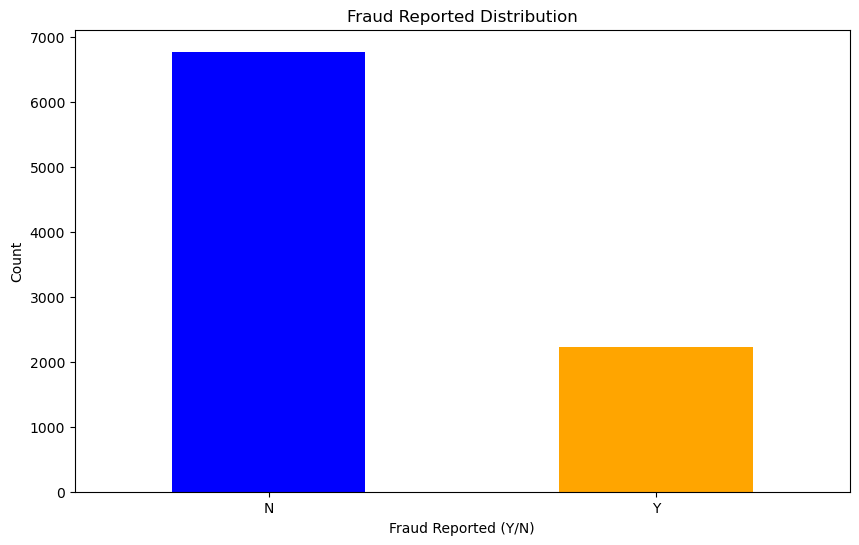

In [465]:
plt.figure(figsize=(10, 6))
df_insurance['fraud_reported'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Fraud Reported Distribution')
plt.xlabel('Fraud Reported (Y/N)')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

# Pre-processing

## Missing Data

In [466]:
# MAR
df_insurance['collision_type'] = df_insurance['collision_type'].apply(lambda x: x.replace('?', 'No Collision'))
df_insurance['authorities_contacted'] = df_insurance['authorities_contacted'].fillna('Unknown because of Incident Type')

# MCAR
df_insurance['property_damage'] = df_insurance['property_damage'].map({'YES': 1, 'NO': 0, '?': 2})

# MCAR
df_insurance['police_report_available'] = df_insurance['police_report_available'].map({'YES': 1, 'NO': 0, '?': 2})

## Adding New Features

In [467]:
df_insurance['policy_bind_date'] = pd.to_datetime(df_insurance['policy_bind_date'])
df_insurance['incident_date'] = pd.to_datetime(df_insurance['incident_date'])
df_insurance['difference_bind_date_incident'] = df_insurance['incident_date'] - df_insurance['policy_bind_date']
df_insurance['difference_bind_date_incident'] = df_insurance['difference_bind_date_incident'].dt.days
df_insurance['difference_model_incident'] = df_insurance['incident_date'].dt.year - df_insurance['auto_year']
df_insurance['same_states'] = np.where((df_insurance['policy_state'] == 'OH') & (df_insurance['incident_state'] == 'OH'), 1, 0)

## Encoding

In [468]:
df_insurance['fraud_reported'] = df_insurance['fraud_reported'].map({'Y': 1, 'N': 0})
df_insurance['policy_bind_date_year'] = pd.to_datetime(df_insurance['policy_bind_date']).dt.year

In [469]:
# Split into X and y
X, y = df_insurance.drop('fraud_reported', axis = 1), df_insurance['fraud_reported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_df = pd.concat([X_train, y_train], axis = 1)
test_df = pd.concat([X_test, y_test], axis = 1)

# EDA

## Functions

In [470]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

def plot_box_density(df, categorical_col, numerical_col):
  """
  Plots a box plot and a density plot for the given categorical and numerical columns.

  Args:
    df: The pandas DataFrame.
    categorical_col: The name of the categorical column.
    numerical_col: The name of the numerical column.
  """
  plt.figure(figsize=(12, 6))

  # Box plot
  plt.subplot(1, 2, 1)
  sns.boxplot(x=categorical_col, y=numerical_col, data=df)
  plt.title(f'Box Plot of {numerical_col} by {categorical_col}')

  # Density plot
  plt.subplot(1, 2, 2)
  sns.kdeplot(data=df, x=numerical_col, hue=categorical_col, fill=True)
  plt.title(f'Density Plot of {numerical_col} by {categorical_col}')

  plt.tight_layout()
  plt.show()

def plot_stacked_bar_chi2(df, stack_col, x_col):
  """
  Plots a stacked bar chart for the given categorical columns and calculates the chi-squared value.

  Args:
    df: The pandas DataFrame.
    x_col: The name of the column for the x-axis labels.
    stack_col: The name of the column for the stacked categories.
  """
  # Create the contingency table
  contingency_table = pd.crosstab(df[x_col], df[stack_col])

  # Plot the stacked bar chart
  ax = contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
  plt.title(f'Stacked Bar Chart of {x_col} by {stack_col}')
  plt.xlabel(x_col)
  plt.ylabel('Count')
  plt.xticks(rotation=0)
  plt.legend(title=stack_col)

  # Calculate the ratio of 1s to all rows for each x_col value
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))

  # Add the ratios to the bottom of the x-axis
  x_coords = range(len(contingency_table.index))
  for i, ratio in enumerate(ratios):
      ax.text(i, -0.1, f'{ratio:.2f}', ha='center', va='bottom', rotation=0)

  plt.show()

  # Calculate the chi-squared value
  chi2, p, _, _ = chi2_contingency(contingency_table)

  # Print the chi-squared value and p-value
  print(f'Chi-squared value: {chi2}')
  print(f'P-value: {p}')

  # Evaluate the output
  if p < 0.05:
    print('There is a significant association between the two variables.')
  else:
    print('There is no significant association between the two variables.')

## Months as Customer

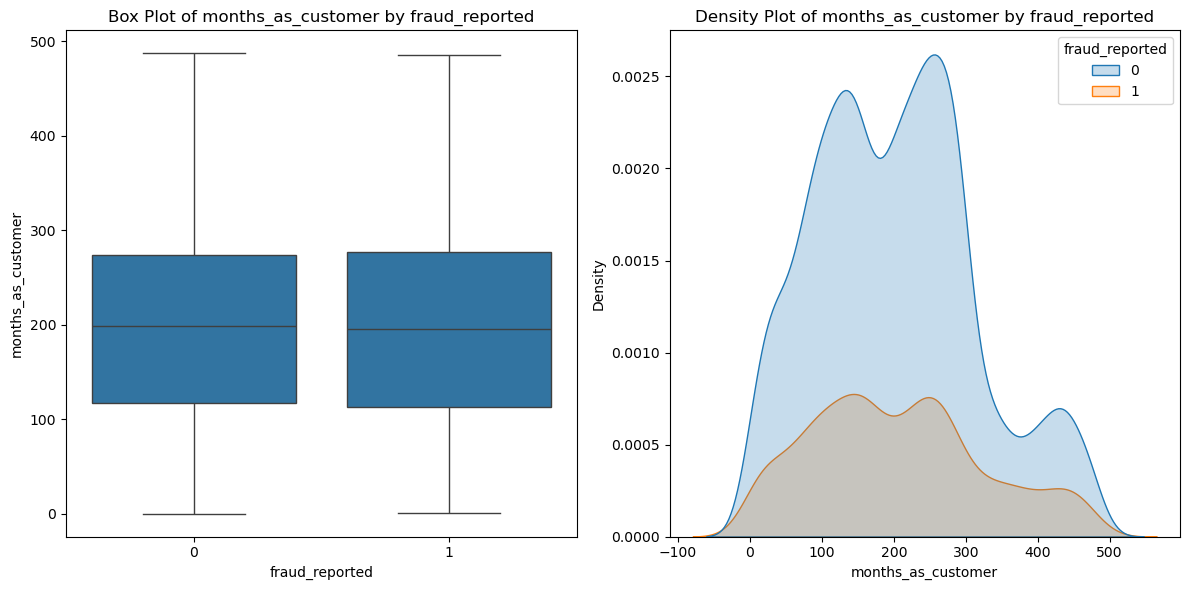

In [471]:
plot_box_density(train_df, 'fraud_reported', 'months_as_customer')

## Age

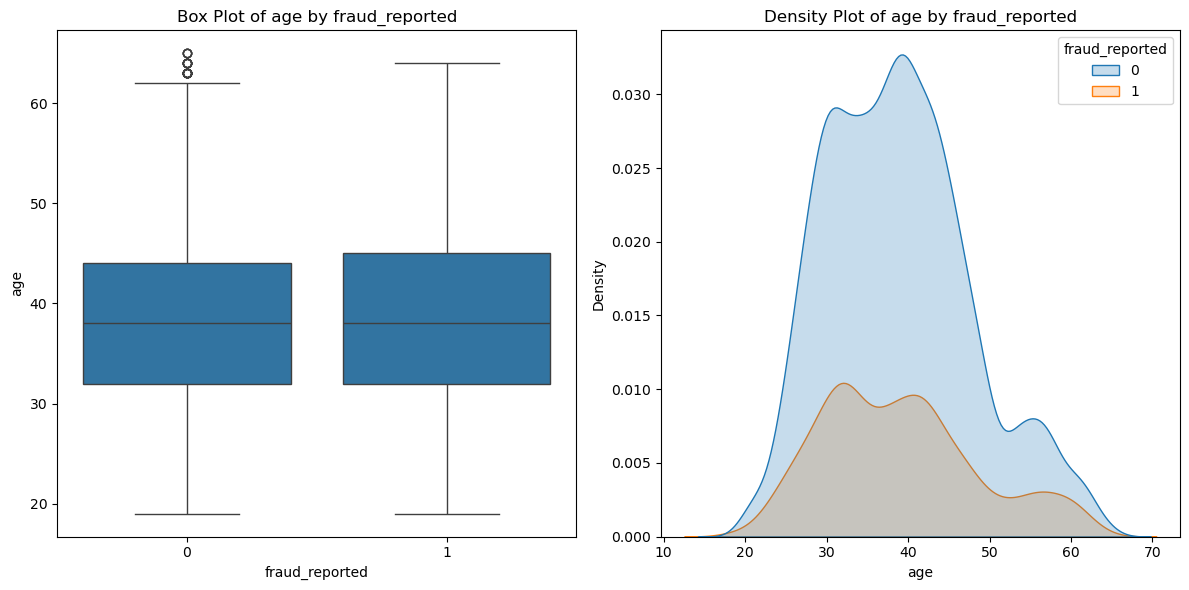

In [472]:
plot_box_density(train_df, 'fraud_reported', 'age')

## Policy Bind Date

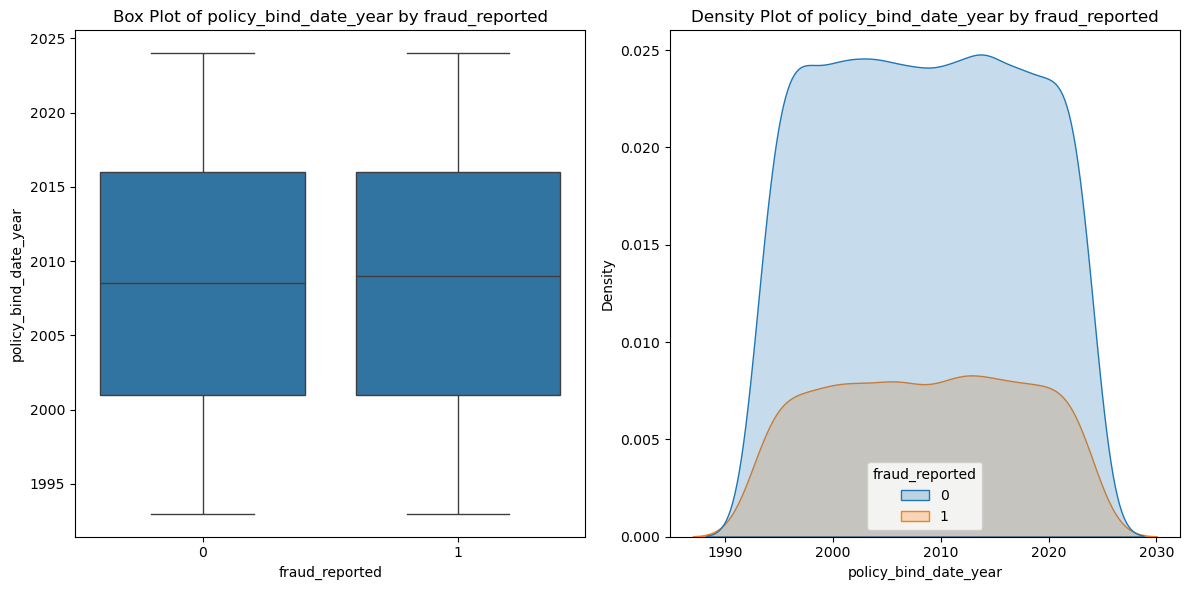

(None,)

In [473]:
plot_box_density(train_df, 'fraud_reported', 'policy_bind_date_year'),

## Policy Total Claim Amount

### Should separate data at the 20000 mark?

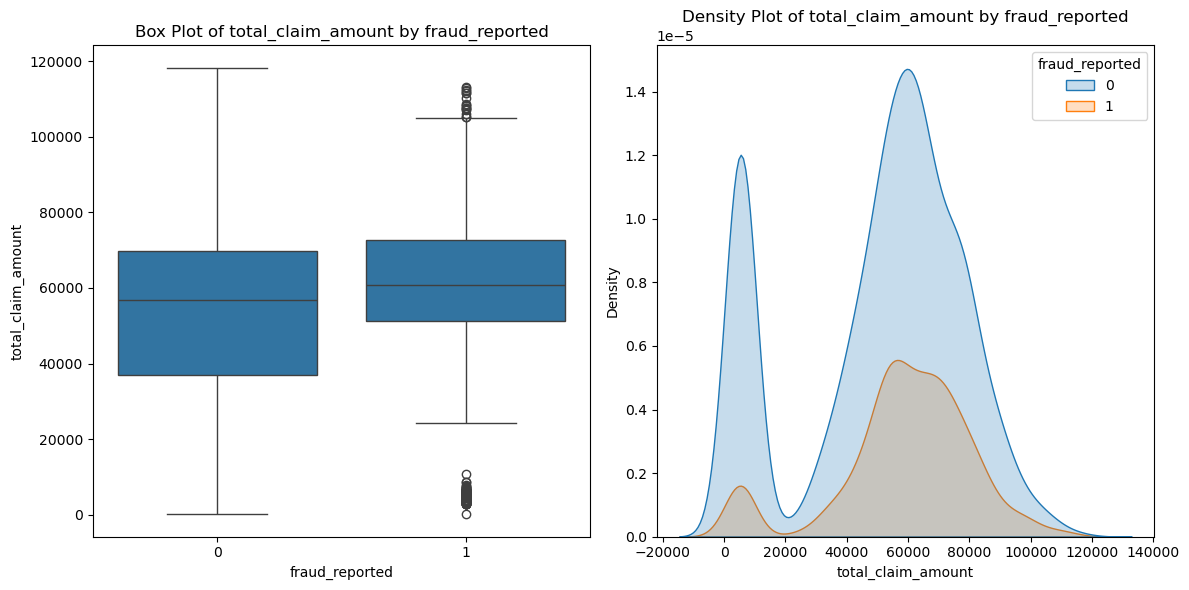

In [474]:
plot_box_density(train_df, 'fraud_reported', 'total_claim_amount')

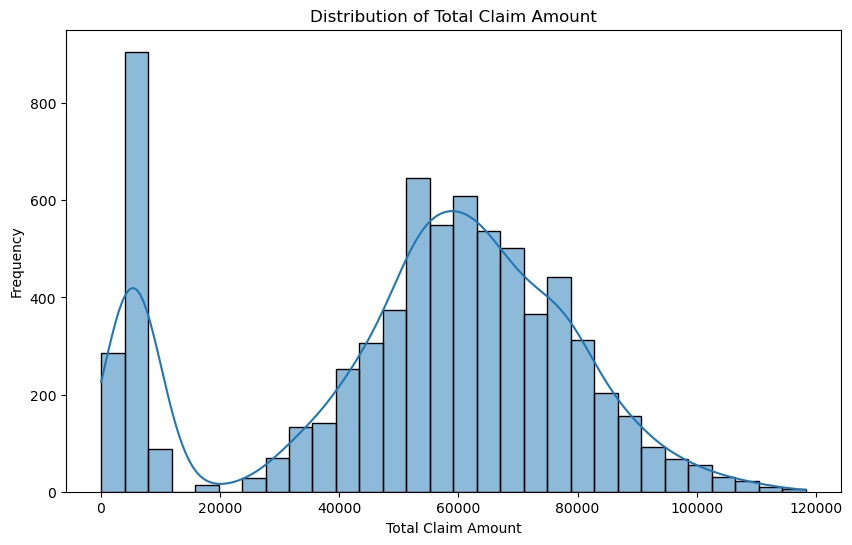

In [475]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_claim_amount'], kde=True, bins=30)
plt.title('Distribution of Total Claim Amount')
plt.xlabel('Total Claim Amount')
plt.ylabel('Frequency')
plt.show()

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


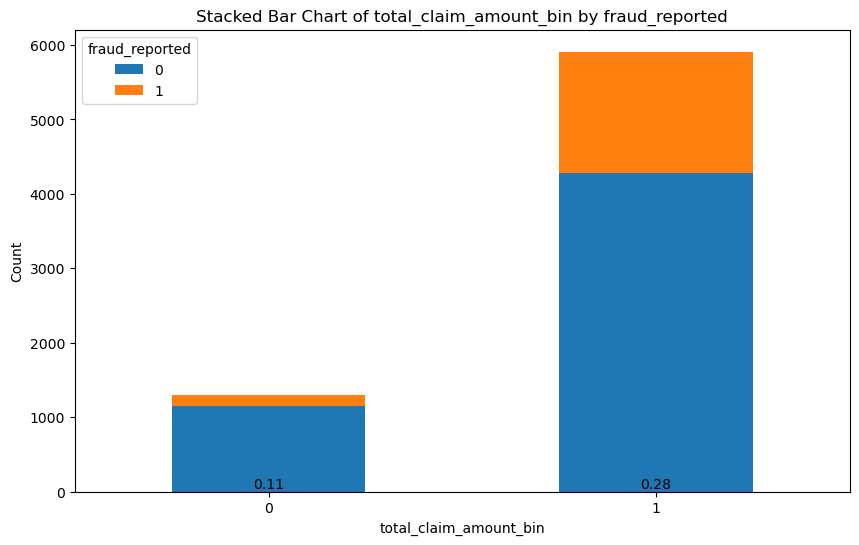

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


Chi-squared value: 148.93867092574388
P-value: 2.9576469451577095e-34
There is a significant association between the two variables.


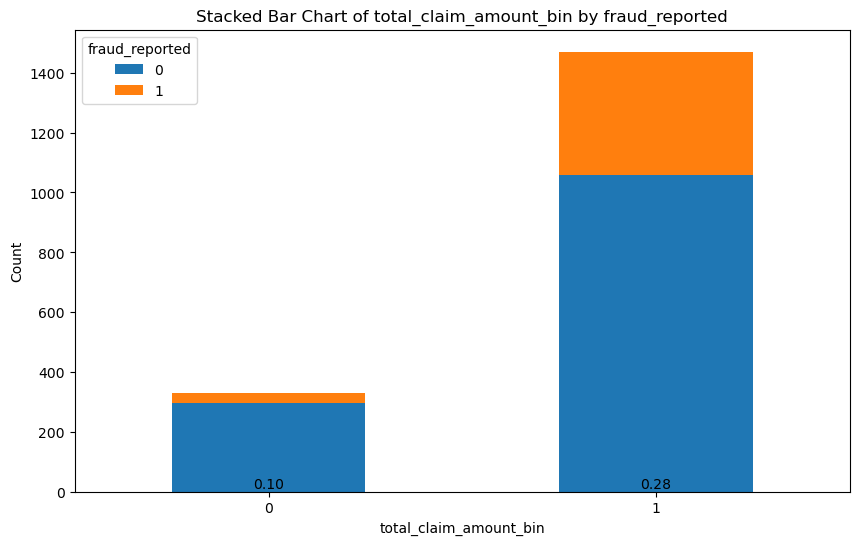

Chi-squared value: 43.84007552857309
P-value: 3.563334567442649e-11
There is a significant association between the two variables.


In [476]:
train_df['total_claim_amount_bin'] = pd.cut(train_df['total_claim_amount'], bins=[0, 20000, float('inf')], labels=[0, 1]).astype(int)
test_df['total_claim_amount_bin'] = pd.cut(test_df['total_claim_amount'], bins=[0, 20000, float('inf')], labels=[0, 1]).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'total_claim_amount_bin')
plot_stacked_bar_chi2(test_df, 'fraud_reported', 'total_claim_amount_bin')

## Injury Claim

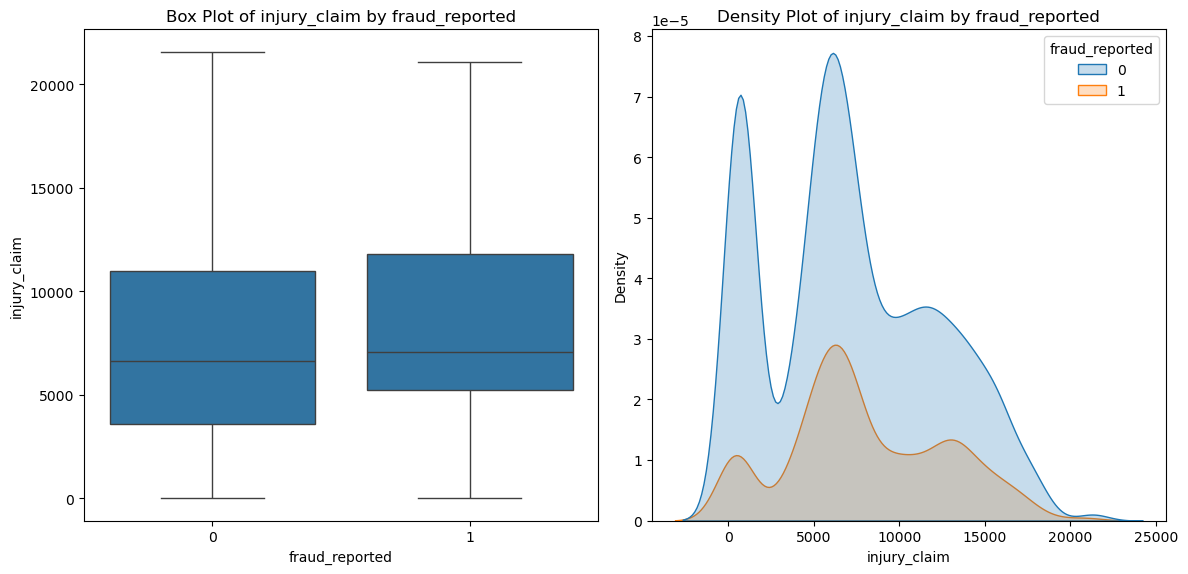

In [477]:
plot_box_density(train_df, 'fraud_reported', 'injury_claim')

In [478]:
# Create bins of size 100 for injury_claim
bins = range(0, int(df_insurance['injury_claim'].max()) + 100, 100)
train_df['injury_claim_bin'] = pd.cut(train_df['injury_claim'], bins=bins)

# Count the number of claims in each bin
train_df.groupby('injury_claim_bin')['injury_claim'].count()[:50]

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3936090510.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby('injury_claim_bin')['injury_claim'].count()[:50]


injury_claim_bin
(0, 100]          8
(100, 200]        0
(200, 300]       52
(300, 400]       48
(400, 500]      192
(500, 600]      179
(600, 700]      207
(700, 800]       84
(800, 900]       98
(900, 1000]      80
(1000, 1100]     67
(1100, 1200]     57
(1200, 1300]     84
(1300, 1400]     39
(1400, 1500]     35
(1500, 1600]      0
(1600, 1700]     13
(1700, 1800]      7
(1800, 1900]      6
(1900, 2000]      2
(2000, 2100]      0
(2100, 2200]      5
(2200, 2300]     11
(2300, 2400]      0
(2400, 2500]      0
(2500, 2600]      0
(2600, 2700]      1
(2700, 2800]     12
(2800, 2900]     14
(2900, 3000]      8
(3000, 3100]     19
(3100, 3200]     12
(3200, 3300]     23
(3300, 3400]     11
(3400, 3500]     19
(3500, 3600]     36
(3600, 3700]     33
(3700, 3800]     20
(3800, 3900]     14
(3900, 4000]     16
(4000, 4100]     33
(4100, 4200]     33
(4200, 4300]     34
(4300, 4400]     36
(4400, 4500]     33
(4500, 4600]     50
(4600, 4700]     47
(4700, 4800]     61
(4800, 4900]     53
(49

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


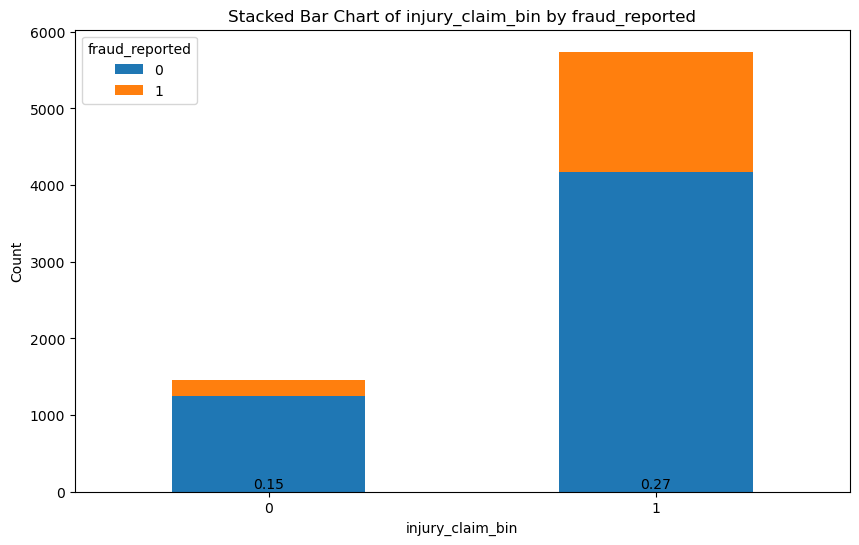

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


Chi-squared value: 99.88629299425912
P-value: 1.6140243840890734e-23
There is a significant association between the two variables.


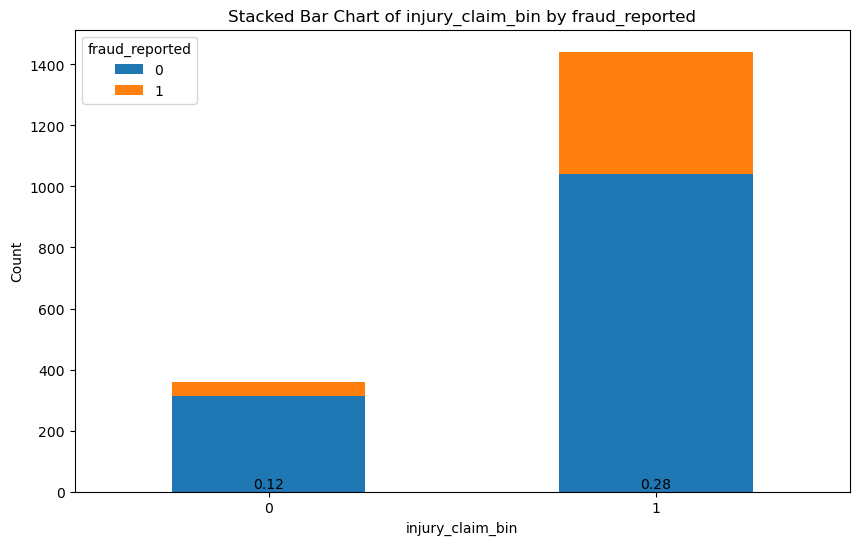

Chi-squared value: 36.281475313687714
P-value: 1.7077945402302614e-09
There is a significant association between the two variables.


In [479]:
train_df['injury_claim_bin'] = pd.cut(train_df['injury_claim'], bins=[-1, 2300, float('inf')], labels=[0, 1]).astype(int)
test_df['injury_claim_bin'] = pd.cut(test_df['injury_claim'], bins=[-1, 2300, float('inf')], labels=[0, 1]).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'injury_claim_bin')
plot_stacked_bar_chi2(test_df, 'fraud_reported', 'injury_claim_bin')

## Property Claim

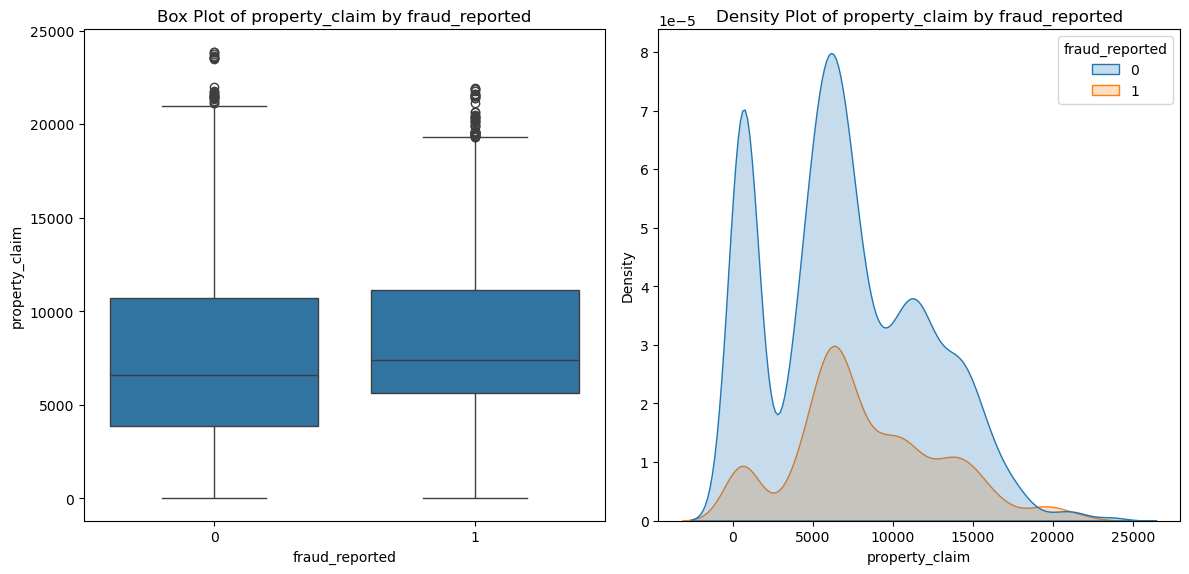

In [480]:
plot_box_density(train_df, 'fraud_reported', 'property_claim')

In [481]:
# Create bins of size 100 for injury_claim
bins = range(0, int(train_df['property_claim'].max()) + 100, 100)
train_df['property_claim_bin'] = pd.cut(train_df['property_claim'], bins=bins)

# Count the number of claims in each bin
train_df.groupby('property_claim_bin')['property_claim'].count()[:50]

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\2018537315.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby('property_claim_bin')['property_claim'].count()[:50]


property_claim_bin
(0, 100]          8
(100, 200]        0
(200, 300]       73
(300, 400]       72
(400, 500]      149
(500, 600]      152
(600, 700]      214
(700, 800]       71
(800, 900]      126
(900, 1000]      90
(1000, 1100]     64
(1100, 1200]     48
(1200, 1300]     82
(1300, 1400]     31
(1400, 1500]     33
(1500, 1600]     16
(1600, 1700]      9
(1700, 1800]     13
(1800, 1900]      3
(1900, 2000]      0
(2000, 2100]      3
(2100, 2200]      3
(2200, 2300]      7
(2300, 2400]      0
(2400, 2500]      0
(2500, 2600]      0
(2600, 2700]      0
(2700, 2800]     11
(2800, 2900]      1
(2900, 3000]      5
(3000, 3100]      1
(3100, 3200]     18
(3200, 3300]     20
(3300, 3400]     15
(3400, 3500]      9
(3500, 3600]     30
(3600, 3700]     18
(3700, 3800]     20
(3800, 3900]     26
(3900, 4000]     19
(4000, 4100]     61
(4100, 4200]     24
(4200, 4300]     34
(4300, 4400]     38
(4400, 4500]     56
(4500, 4600]     35
(4600, 4700]     53
(4700, 4800]     70
(4800, 4900]     65
(

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


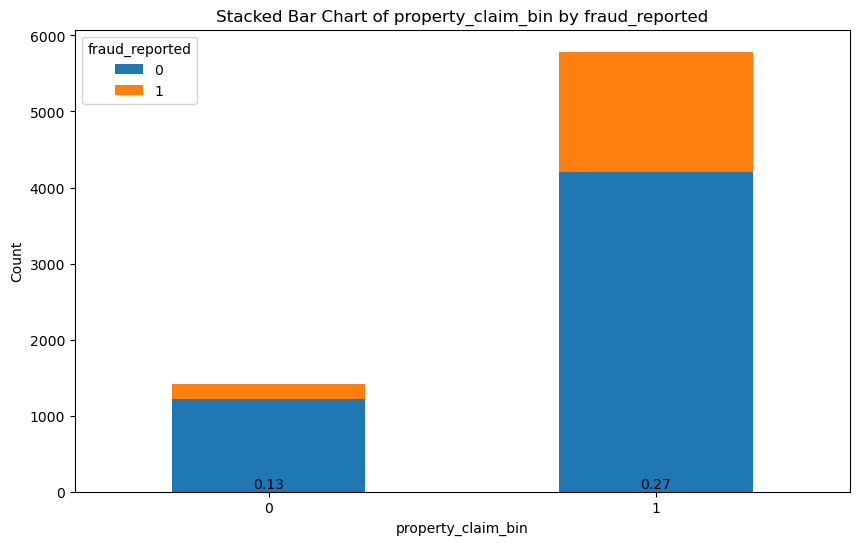

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


Chi-squared value: 118.5432005199104
P-value: 1.318510041947407e-27
There is a significant association between the two variables.


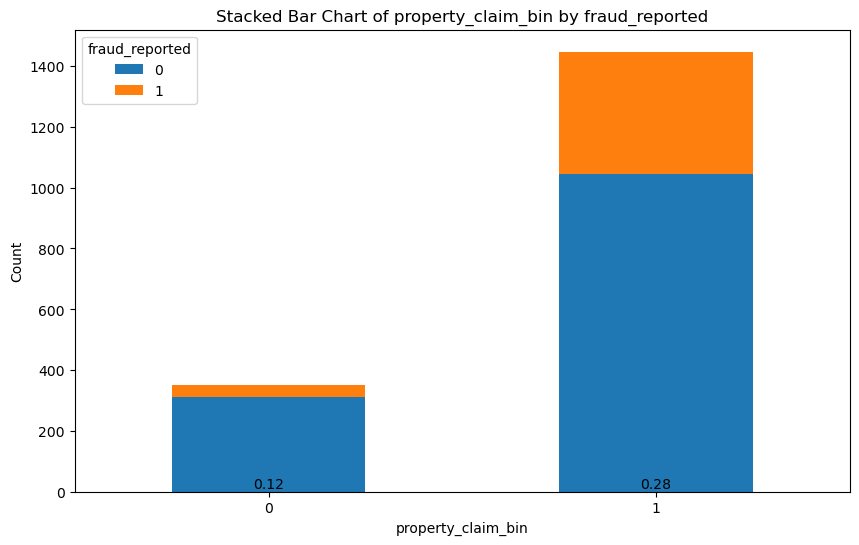

Chi-squared value: 39.32365641031227
P-value: 3.590646379094987e-10
There is a significant association between the two variables.


In [482]:
train_df['property_claim_bin'] = pd.cut(train_df['property_claim'], bins=[-1, 2300, float('inf')], labels=[0, 1]).astype(int)
test_df['property_claim_bin'] = pd.cut(test_df['property_claim'], bins=[-1, 2300, float('inf')], labels=[0, 1]).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'property_claim_bin')
plot_stacked_bar_chi2(test_df, 'fraud_reported', 'property_claim_bin')

## Vehicle Claim

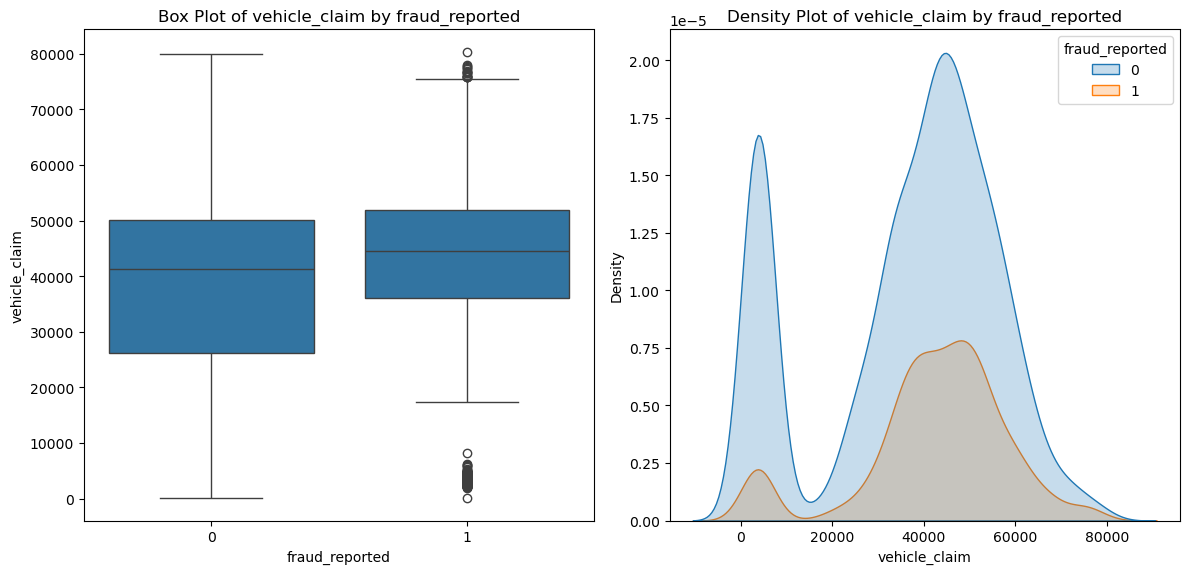

In [483]:
plot_box_density(train_df, 'fraud_reported', 'vehicle_claim')

In [484]:
# Create bins of size 1000 for vehicle_claim
bins = range(0, int(train_df['vehicle_claim'].max()) + 1000, 1000)
train_df['vehicle_claim_bin'] = pd.cut(train_df['vehicle_claim'], bins=bins)

# Count the number of claims in each bin
vehicle_claim_counts = train_df.groupby('vehicle_claim_bin')['vehicle_claim'].count()

vehicle_claim_counts[:30]

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\2922389047.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vehicle_claim_counts = train_df.groupby('vehicle_claim_bin')['vehicle_claim'].count()


vehicle_claim_bin
(0, 1000]           8
(1000, 2000]       71
(2000, 3000]      251
(3000, 4000]      352
(4000, 5000]      341
(5000, 6000]      177
(6000, 7000]       70
(7000, 8000]        0
(8000, 9000]        8
(9000, 10000]       0
(10000, 11000]      0
(11000, 12000]      0
(12000, 13000]      6
(13000, 14000]      7
(14000, 15000]      0
(15000, 16000]      0
(16000, 17000]      1
(17000, 18000]     16
(18000, 19000]      3
(19000, 20000]      9
(20000, 21000]      8
(21000, 22000]     31
(22000, 23000]     29
(23000, 24000]     22
(24000, 25000]     60
(25000, 26000]     57
(26000, 27000]     79
(27000, 28000]     45
(28000, 29000]     52
(29000, 30000]     83
Name: vehicle_claim, dtype: int64

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


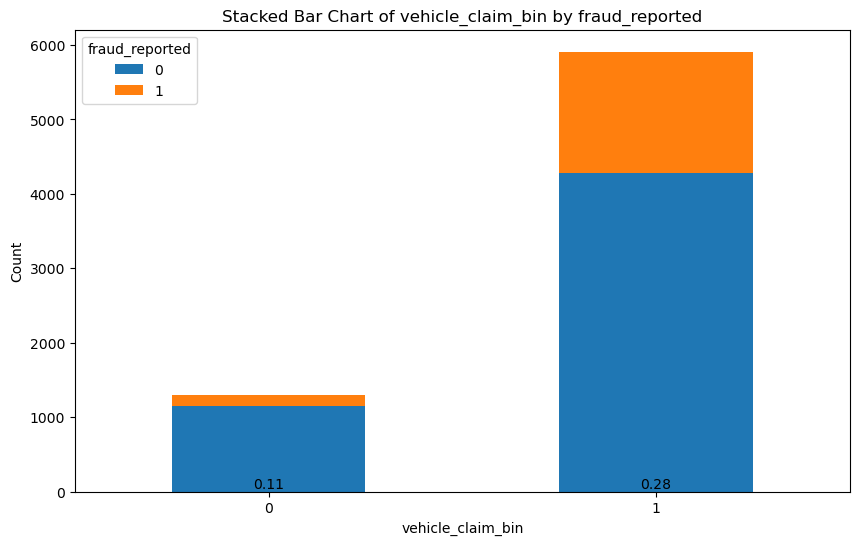

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


Chi-squared value: 148.93867092574388
P-value: 2.9576469451577095e-34
There is a significant association between the two variables.


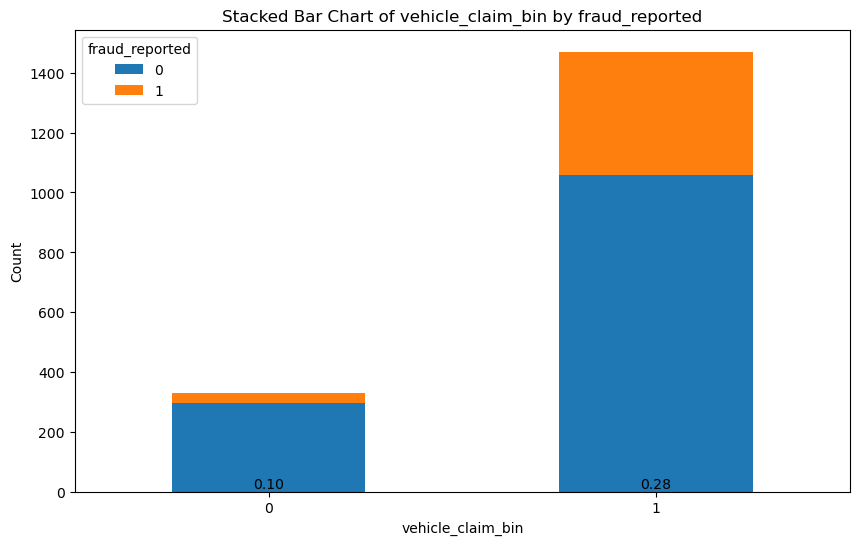

Chi-squared value: 43.84007552857309
P-value: 3.563334567442649e-11
There is a significant association between the two variables.


In [485]:
train_df['vehicle_claim_bin'] = pd.cut(train_df['vehicle_claim'], bins=[0, 15000, float('inf')], labels=[0, 1]).astype(int)
test_df['vehicle_claim_bin'] = pd.cut(test_df['vehicle_claim'], bins=[0, 15000, float('inf')], labels=[0, 1]).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'vehicle_claim_bin')
plot_stacked_bar_chi2(test_df, 'fraud_reported', 'vehicle_claim_bin')

## Auto Make

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


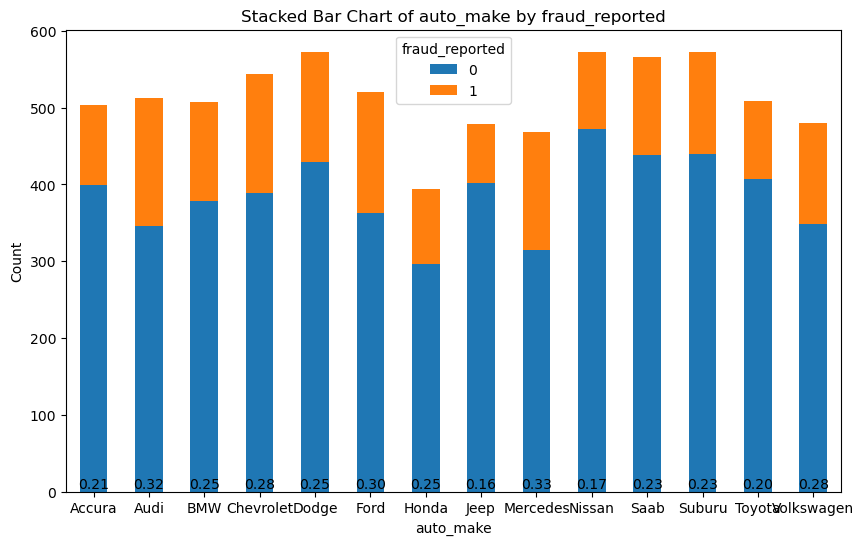

Chi-squared value: 94.95656464756624
P-value: 1.5636196151582473e-14
There is a significant association between the two variables.


In [486]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'auto_make')

## Auto Model

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


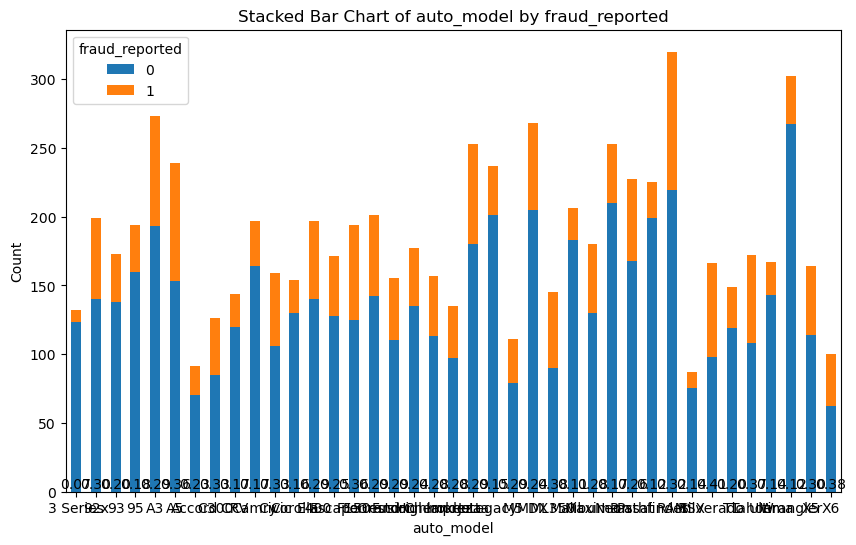

Chi-squared value: 283.8088266782885
P-value: 2.2892378447711554e-39
There is a significant association between the two variables.


In [487]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'auto_model')

## Auto Year

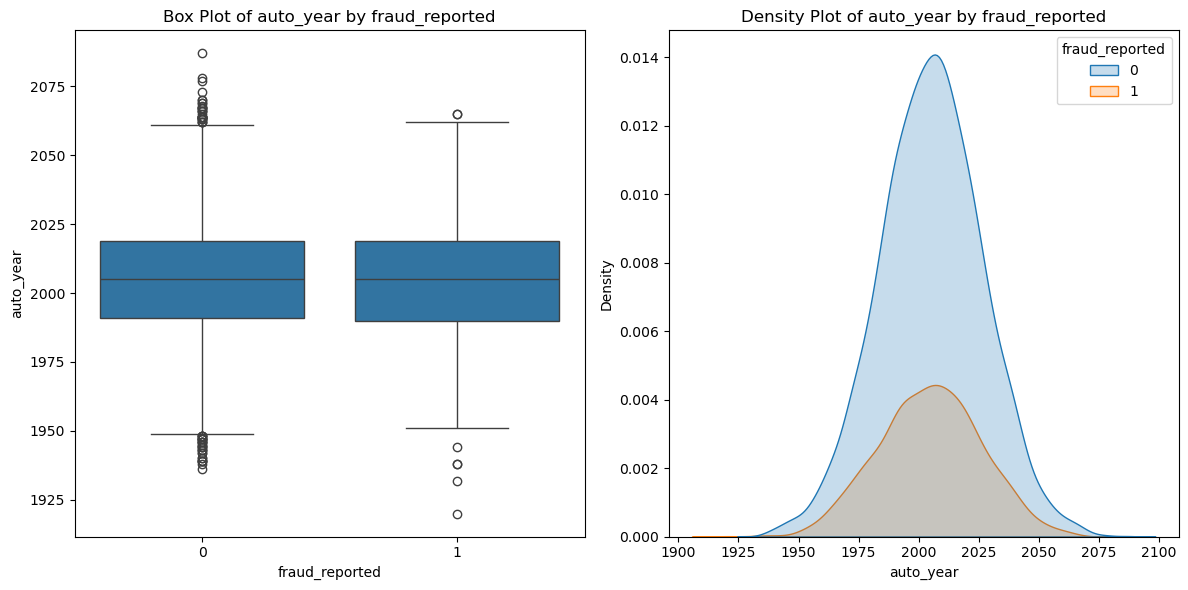

In [488]:
plot_box_density(train_df, 'fraud_reported', 'auto_year')

## Policy Annual Premium

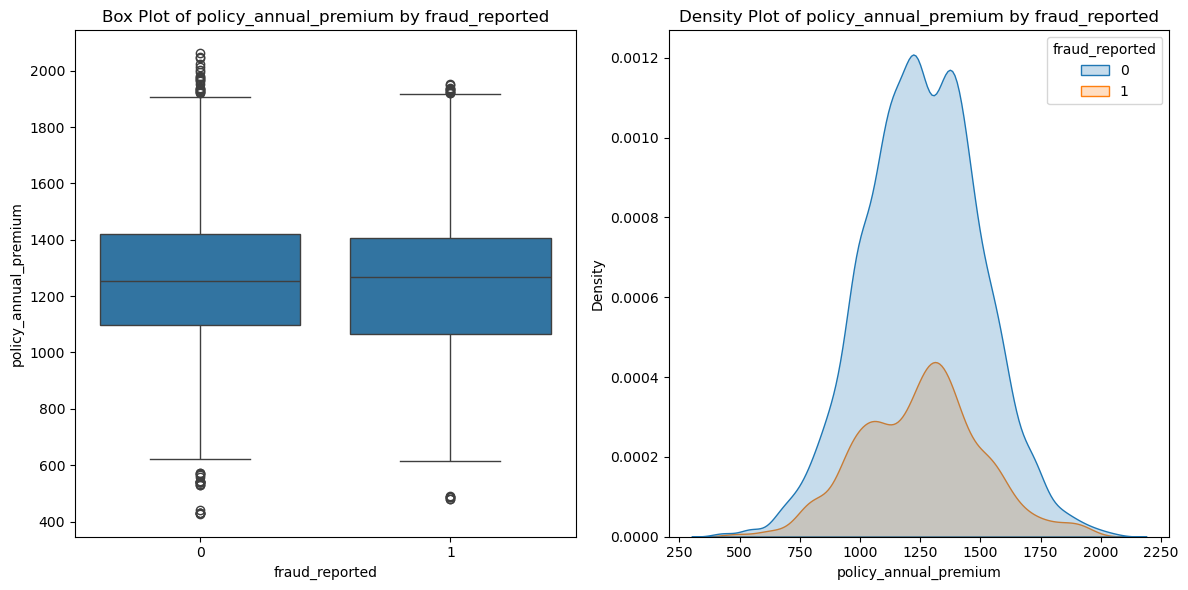

In [489]:
plot_box_density(train_df, 'fraud_reported', 'policy_annual_premium')

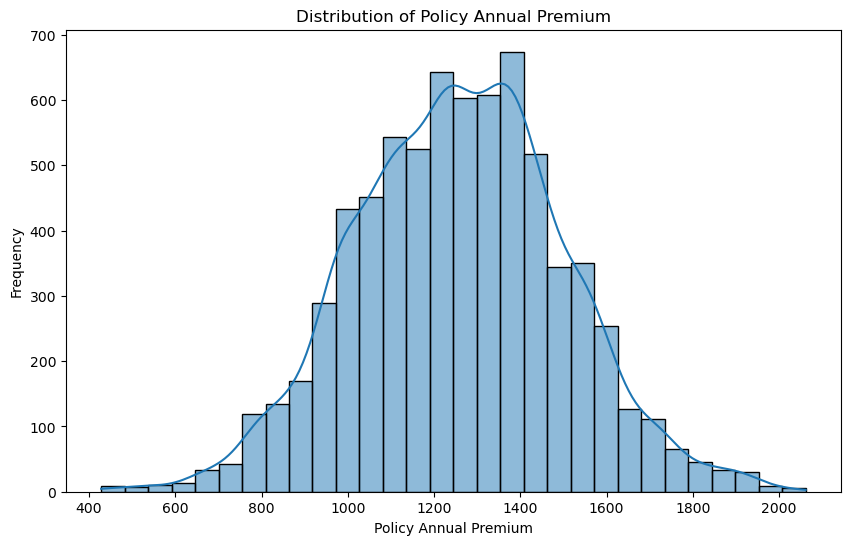

In [490]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['policy_annual_premium'], kde=True, bins=30)
plt.title('Distribution of Policy Annual Premium')
plt.xlabel('Policy Annual Premium')
plt.ylabel('Frequency')
plt.show()

## Policy State

Visually seems quite evenly spread??

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


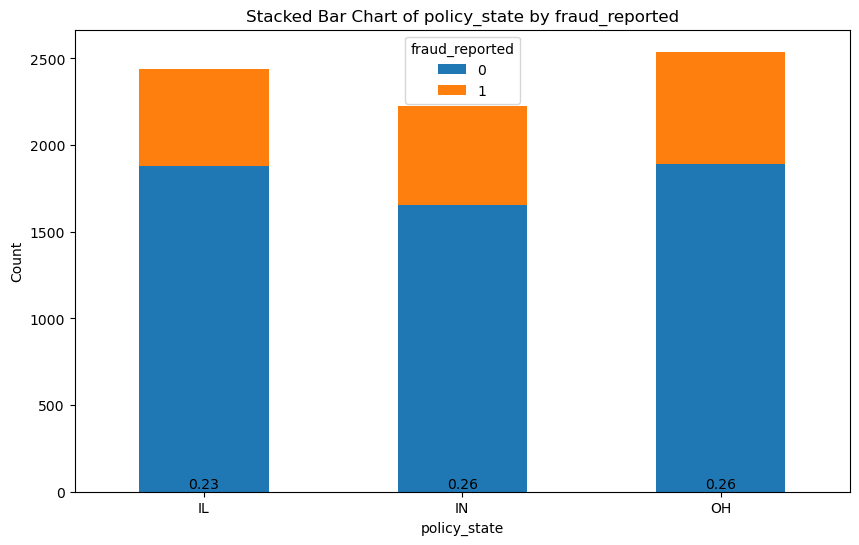

Chi-squared value: 6.695773008056105
P-value: 0.03515858315568883
There is a significant association between the two variables.


In [491]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'policy_state')

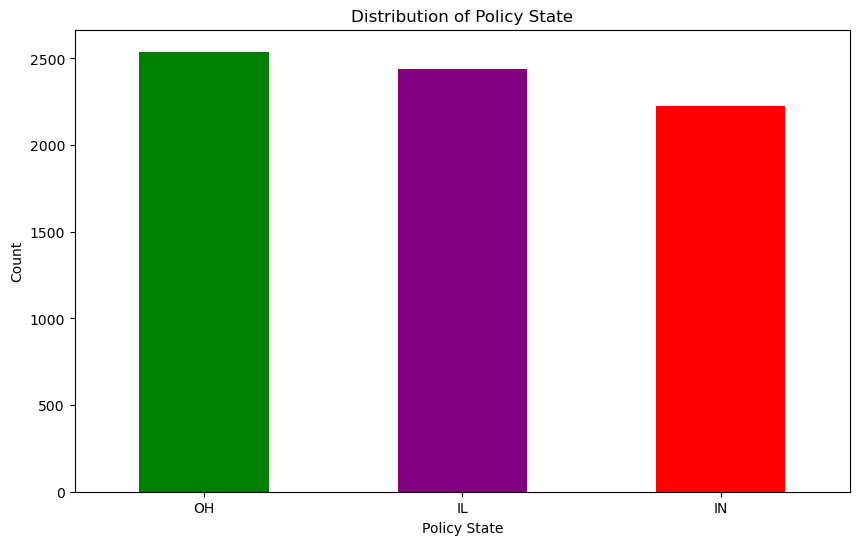

In [492]:
plt.figure(figsize=(10, 6))
train_df['policy_state'].value_counts().plot(kind='bar', color=['green', 'purple', 'red'])
plt.title('Distribution of Policy State')
plt.xlabel('Policy State')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

## Policy csl

500/1000 policy significantly different from 100/300

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


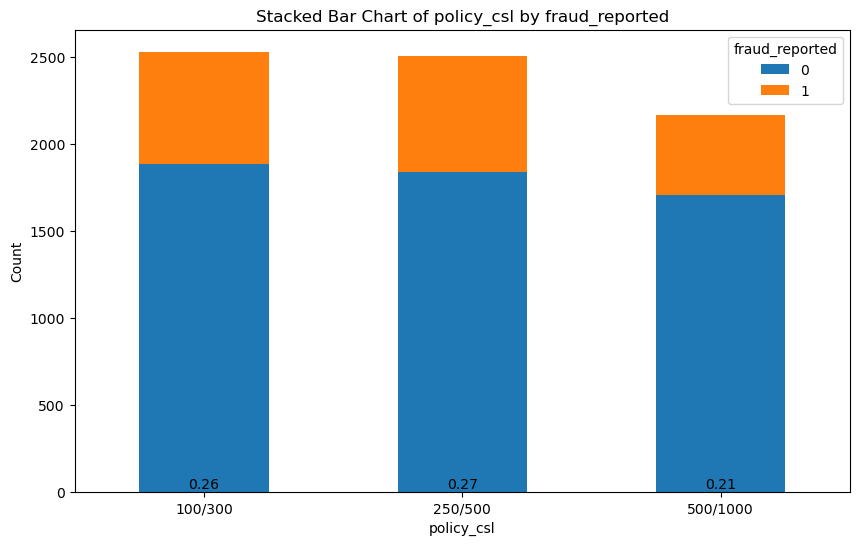

Chi-squared value: 18.60286402965395
P-value: 9.129340431872474e-05
There is a significant association between the two variables.


In [493]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'policy_csl')

## Policy Deductable

Bin this to 500, 1000, 2000?

In [494]:
# Bin 'policy_deductable' into bins of size 50
bins = range(min(train_df['policy_deductable']), max(train_df['policy_deductable']) + 50, 50)
train_df['policy_deductable_bin'] = pd.cut(train_df['policy_deductable'], bins=bins)

# Count the number of observations in each bin
bin_counts = train_df.groupby('policy_deductable_bin')['policy_deductable'].count()

bin_counts

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\82885763.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = train_df.groupby('policy_deductable_bin')['policy_deductable'].count()


policy_deductable_bin
(484, 534]      2478
(534, 584]         0
(584, 634]         0
(634, 684]         0
(684, 734]         0
(734, 784]         0
(784, 834]         0
(834, 884]         0
(884, 934]         0
(934, 984]       158
(984, 1034]     2352
(1034, 1084]       3
(1084, 1134]       0
(1134, 1184]       0
(1184, 1234]       0
(1234, 1284]       0
(1284, 1334]       0
(1334, 1384]       0
(1384, 1434]       0
(1434, 1484]       0
(1484, 1534]       0
(1534, 1584]       0
(1584, 1634]       0
(1634, 1684]       0
(1684, 1734]       0
(1734, 1784]       0
(1784, 1834]       0
(1834, 1884]       0
(1884, 1934]       1
(1934, 1984]     504
(1984, 2034]    1633
(2034, 2084]      69
Name: policy_deductable, dtype: int64

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


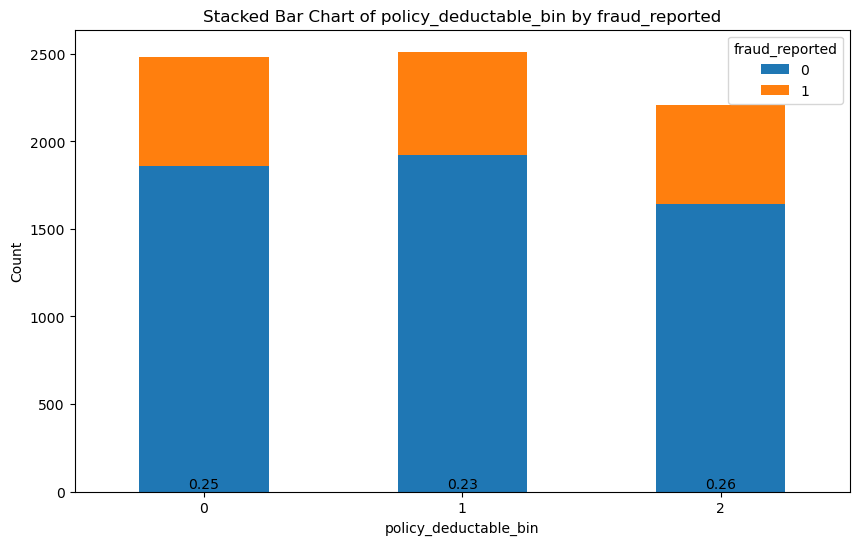

Chi-squared value: 3.510393098465302
P-value: 0.17287326084554716
There is no significant association between the two variables.


In [495]:
# Bin 'policy_deductable' into 3 bins, cutting at 800 and 1500
bins = [0, 800, 1500, float('inf')]
labels = [0, 1, 2]
train_df['policy_deductable_bin'] = pd.cut(train_df['policy_deductable'], bins=bins, labels=labels, include_lowest=True).astype(int)
test_df['policy_deductable_bin'] = pd.cut(test_df['policy_deductable'], bins=bins, labels=labels, include_lowest=True).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'policy_deductable_bin')

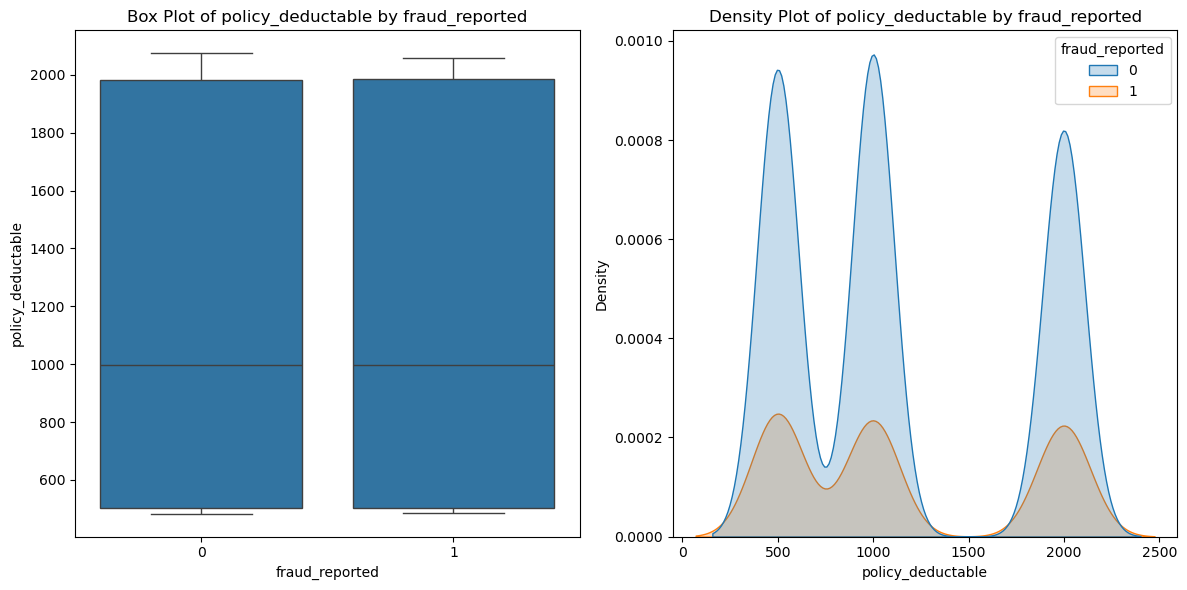

In [496]:
plot_box_density(train_df, 'fraud_reported', 'policy_deductable')

## Umbrella Limit

Bin outliers and normal

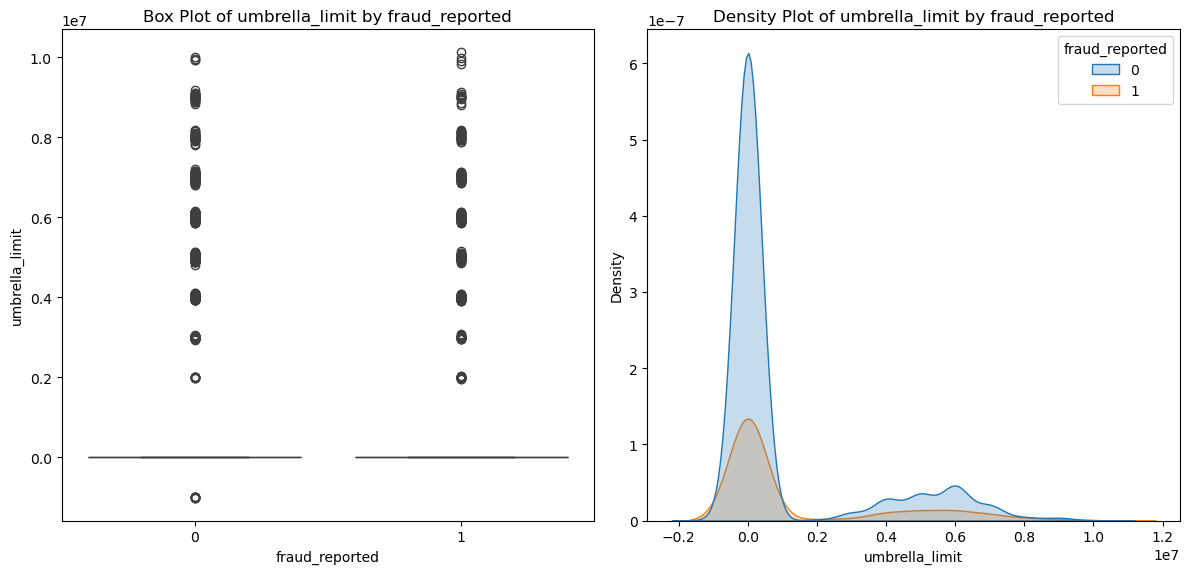

In [497]:
plot_box_density(train_df, 'fraud_reported', 'umbrella_limit')

## Insured Sex

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


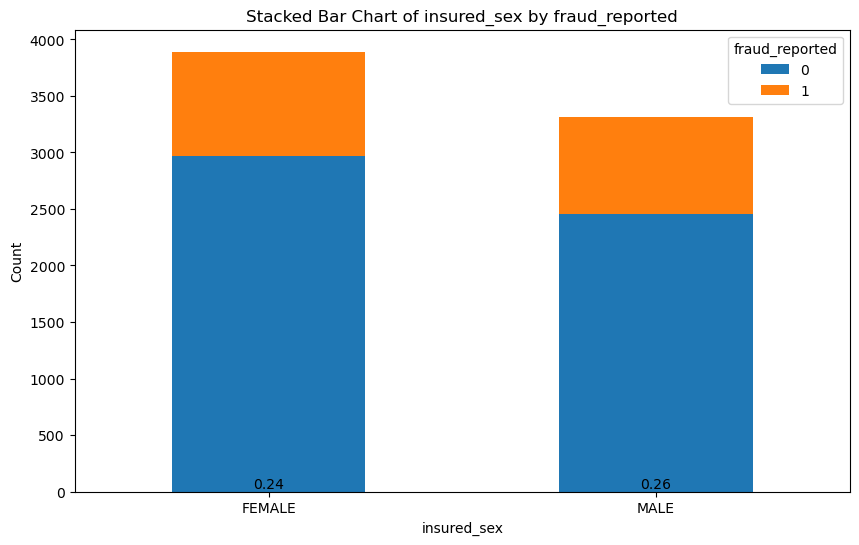

Chi-squared value: 4.197409398864409
P-value: 0.04048578323400069
There is a significant association between the two variables.


In [498]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'insured_sex')

## Insured Education Level

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


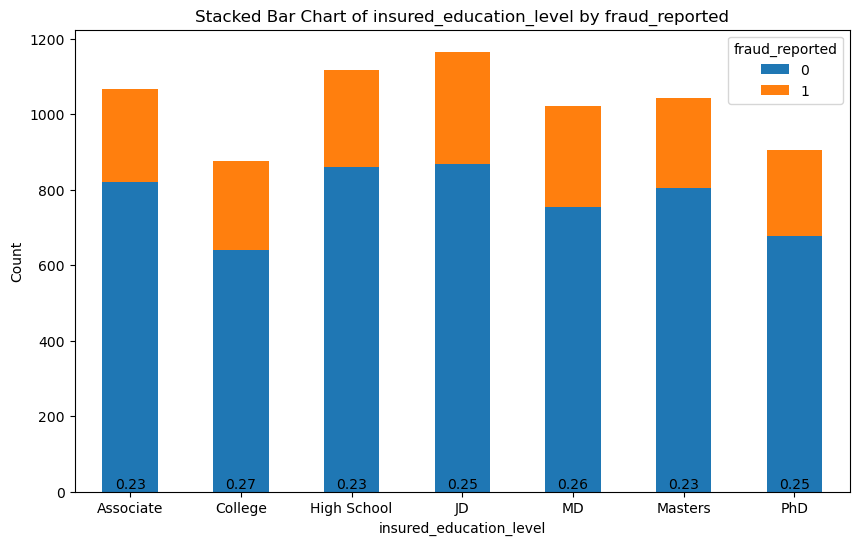

Chi-squared value: 9.58917362481463
P-value: 0.1430532361747739
There is no significant association between the two variables.


In [499]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'insured_education_level')

## Insured Occupation

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


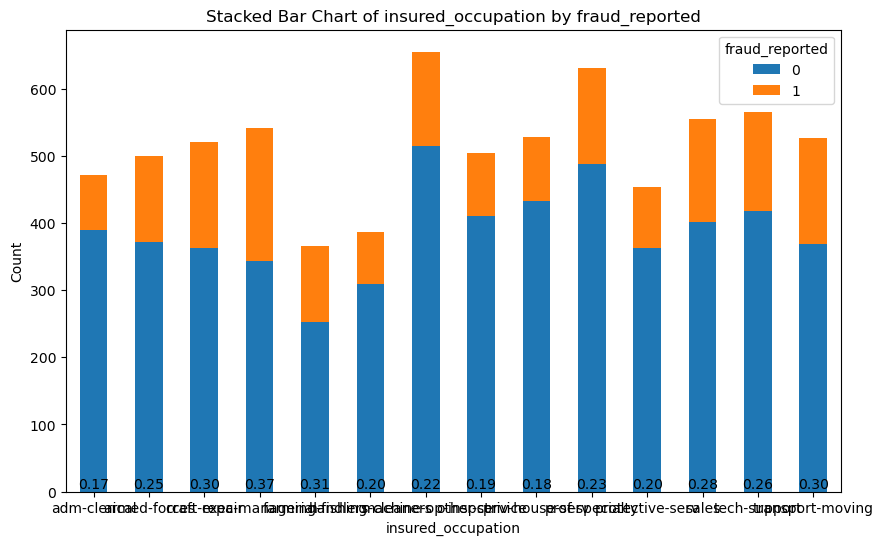

Chi-squared value: 119.45448541532784
P-value: 2.5804269486177857e-19
There is a significant association between the two variables.


In [500]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'insured_occupation')

## Insured Hobbies

In [501]:
train_df.groupby('insured_hobbies')['fraud_reported'].mean()
# df_insurance['insured_hobbies'] = df_insurance['insured_hobbies'].str.split(',').apply(len)
# plot_box_density(df_insurance, 'fraud_reported', 'insured_hobbies')

insured_hobbies
base-jumping      0.277778
basketball        0.158996
board-games       0.280899
bungie-jumping    0.188442
camping           0.102244
chess             0.758209
cross-fit         0.691358
dancing           0.143322
exercise          0.191038
golf              0.144963
hiking            0.210084
kayaking          0.117647
movies            0.166240
paintball         0.250627
polo              0.266467
reading           0.267782
skydiving         0.228883
sleeping          0.187713
video-games       0.196676
yachting          0.291777
Name: fraud_reported, dtype: float64

## Insured Relationship

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


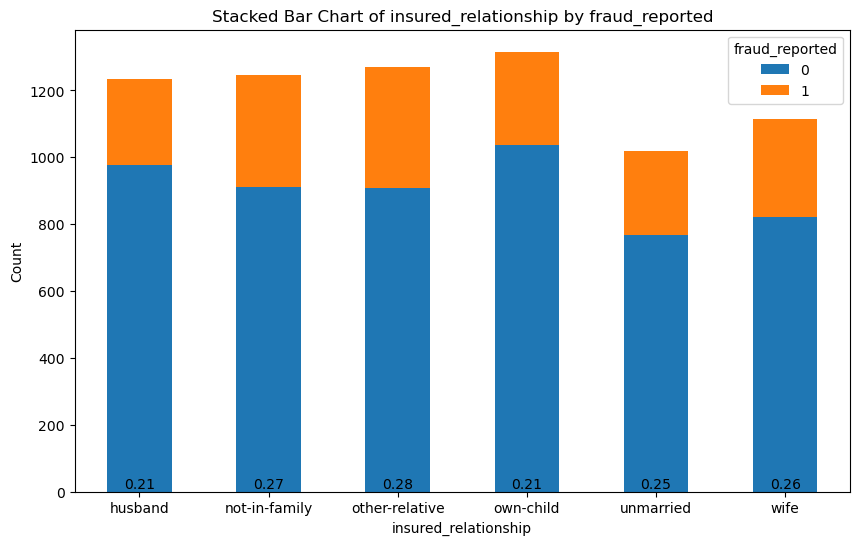

Chi-squared value: 31.635218692991387
P-value: 7.01576091170315e-06
There is a significant association between the two variables.


In [502]:
train_df.groupby('insured_relationship')['fraud_reported'].mean()
# df_insurance['insured_hobbies'] = df_insurance['insured_hobbies'].str.split(',').apply(len)
# plot_box_density(df_insurance, 'fraud_reported', 'insured_hobbies')
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'insured_relationship')

## Capital Gains

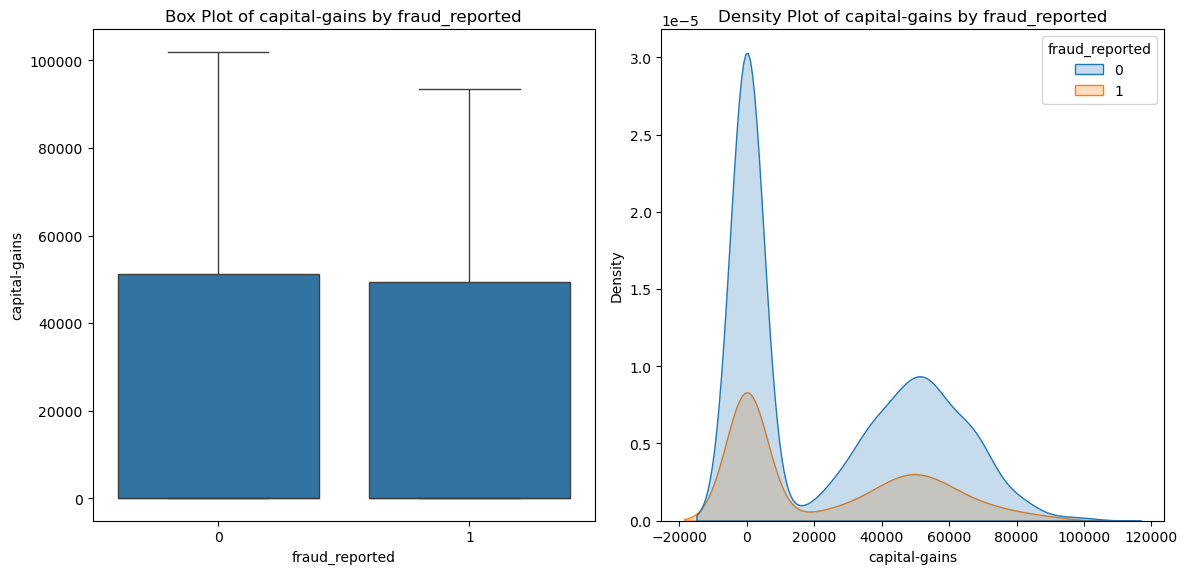

In [503]:
plot_box_density(train_df, 'fraud_reported', 'capital-gains')

In [504]:
# Create bins of size 1000 for vehicle_claim
bins = range(0, int(train_df['capital-gains'].max()) + 1000, 1000)
train_df['capital-gains_bin'] = pd.cut(train_df['capital-gains'], bins=bins)

# Count the number of claims in each bin
vehicle_claim_counts = train_df.groupby('capital-gains_bin')['capital-gains'].count()

# Print the counts for the first 30 bins
print(vehicle_claim_counts[:30])

train_df.drop('capital-gains_bin', axis = 1, inplace = True)

capital-gains_bin
(0, 1000]          7
(1000, 2000]       0
(2000, 3000]       0
(3000, 4000]       0
(4000, 5000]       0
(5000, 6000]       0
(6000, 7000]       0
(7000, 8000]       0
(8000, 9000]       0
(9000, 10000]      3
(10000, 11000]     5
(11000, 12000]     5
(12000, 13000]    14
(13000, 14000]     9
(14000, 15000]     7
(15000, 16000]     1
(16000, 17000]     6
(17000, 18000]    15
(18000, 19000]     0
(19000, 20000]     5
(20000, 21000]    16
(21000, 22000]    16
(22000, 23000]     7
(23000, 24000]    22
(24000, 25000]    29
(25000, 26000]    25
(26000, 27000]    38
(27000, 28000]    35
(28000, 29000]    21
(29000, 30000]    42
Name: capital-gains, dtype: int64


C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\1979890099.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vehicle_claim_counts = train_df.groupby('capital-gains_bin')['capital-gains'].count()


C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


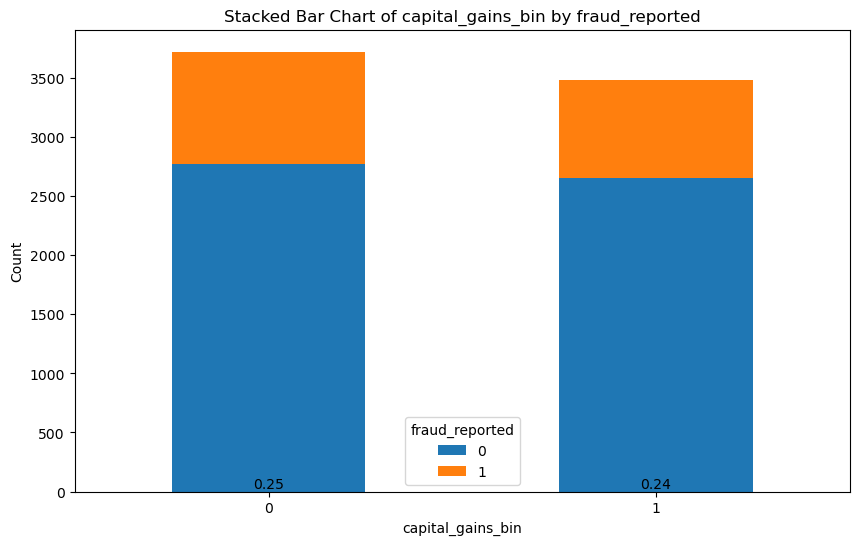

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


Chi-squared value: 2.4497566720625503
P-value: 0.11754308797450203
There is no significant association between the two variables.


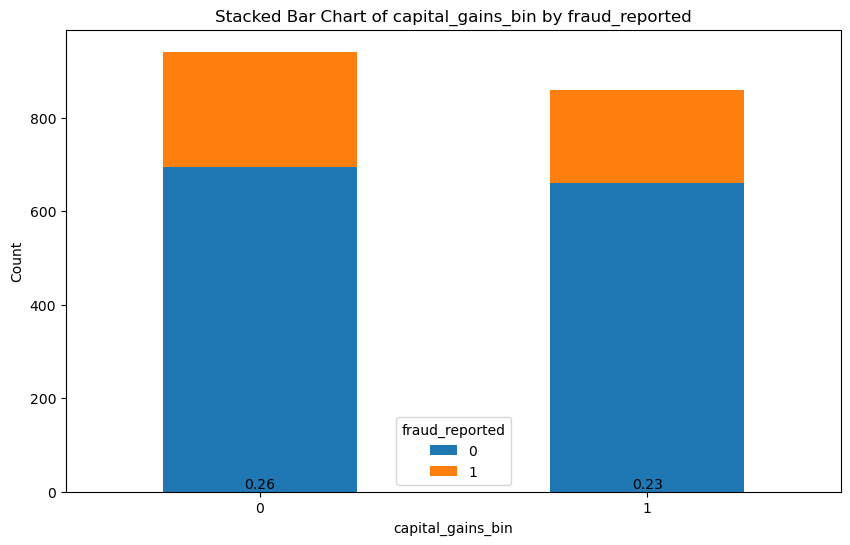

Chi-squared value: 1.9800674398650187
P-value: 0.15938330230532058
There is no significant association between the two variables.


In [505]:
# Bin 'capital-gains' at 19000
bins = [-float('inf'), 19000, float('inf')]
labels = [0, 1]
train_df['capital_gains_bin'] = pd.cut(train_df['capital-gains'], bins=bins, labels=labels, include_lowest=True).astype(int)
test_df['capital_gains_bin'] = pd.cut(test_df['capital-gains'], bins=bins, labels=labels, include_lowest=True).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'capital_gains_bin')
plot_stacked_bar_chi2(test_df, 'fraud_reported', 'capital_gains_bin')

## Capital Loss

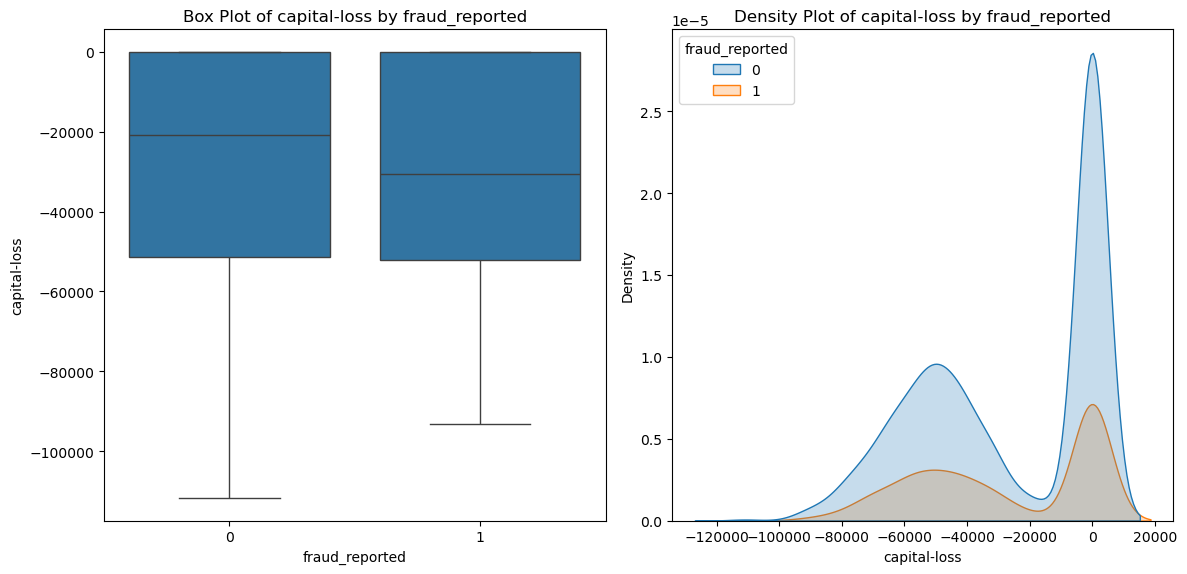

In [506]:
plot_box_density(train_df, 'fraud_reported', 'capital-loss')

In [507]:
# Create bins of size 1000 for vehicle_claim
bins = range(int(train_df['capital-loss'].min()), int(train_df['capital-loss'].max()) + 1000, 1000)
train_df['capital-loss_bin'] = pd.cut(train_df['capital-loss'], bins=bins)

# Count the number of claims in each bin
vehicle_claim_counts = train_df.groupby('capital-loss_bin')['capital-loss'].count()

# Print the counts for the first 30 bins
print(vehicle_claim_counts[60:100])

train_df.drop('capital-loss_bin', axis = 1, inplace = True)

capital-loss_bin
(-51788, -50788]    101
(-50788, -49788]    115
(-49788, -48788]    133
(-48788, -47788]     85
(-47788, -46788]     60
(-46788, -45788]     75
(-45788, -44788]     93
(-44788, -43788]    111
(-43788, -42788]     97
(-42788, -41788]     79
(-41788, -40788]     96
(-40788, -39788]     69
(-39788, -38788]     86
(-38788, -37788]     60
(-37788, -36788]     51
(-36788, -35788]     54
(-35788, -34788]     42
(-34788, -33788]     28
(-33788, -32788]     67
(-32788, -31788]     96
(-31788, -30788]     71
(-30788, -29788]     51
(-29788, -28788]     25
(-28788, -27788]     32
(-27788, -26788]     27
(-26788, -25788]     10
(-25788, -24788]      0
(-24788, -23788]     35
(-23788, -22788]      1
(-22788, -21788]     31
(-21788, -20788]     17
(-20788, -19788]     21
(-19788, -18788]     17
(-18788, -17788]      5
(-17788, -16788]      6
(-16788, -15788]     12
(-15788, -14788]     16
(-14788, -13788]      5
(-13788, -12788]      9
(-12788, -11788]      9
Name: capital-loss, dty

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\2418040232.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vehicle_claim_counts = train_df.groupby('capital-loss_bin')['capital-loss'].count()


C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


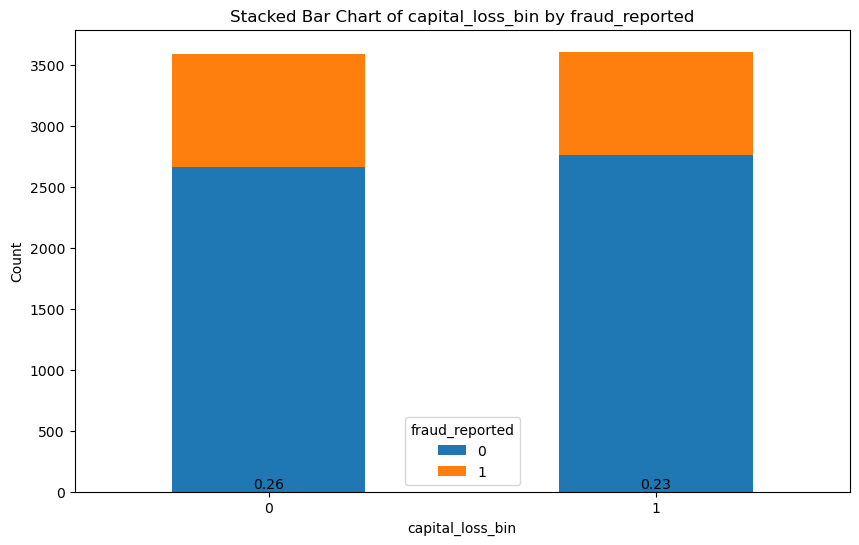

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


Chi-squared value: 5.711022945763562
P-value: 0.016858712795473876
There is a significant association between the two variables.


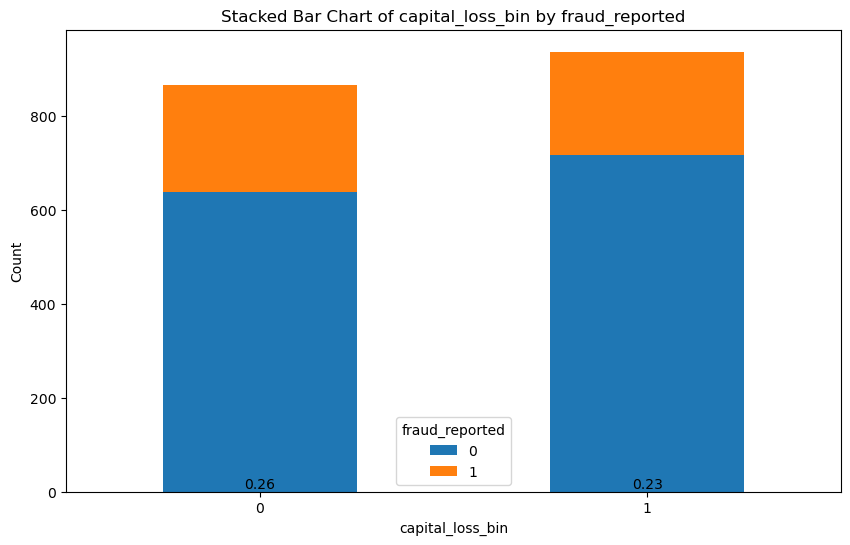

Chi-squared value: 1.6936456097490962
P-value: 0.19312109392783605
There is no significant association between the two variables.


In [508]:
# Bin 'capital-gains' at 19000
bins = [-float('inf'), -25000, float('inf')]
labels = [0, 1]
train_df['capital_loss_bin'] = pd.cut(train_df['capital-loss'], bins=bins, labels=labels, include_lowest=True).astype(int)
test_df['capital_loss_bin'] = pd.cut(test_df['capital-loss'], bins=bins, labels=labels, include_lowest=True).astype(int)

plot_stacked_bar_chi2(train_df, 'fraud_reported', 'capital_loss_bin')
plot_stacked_bar_chi2(test_df, 'fraud_reported', 'capital_loss_bin')

## Incident Type

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


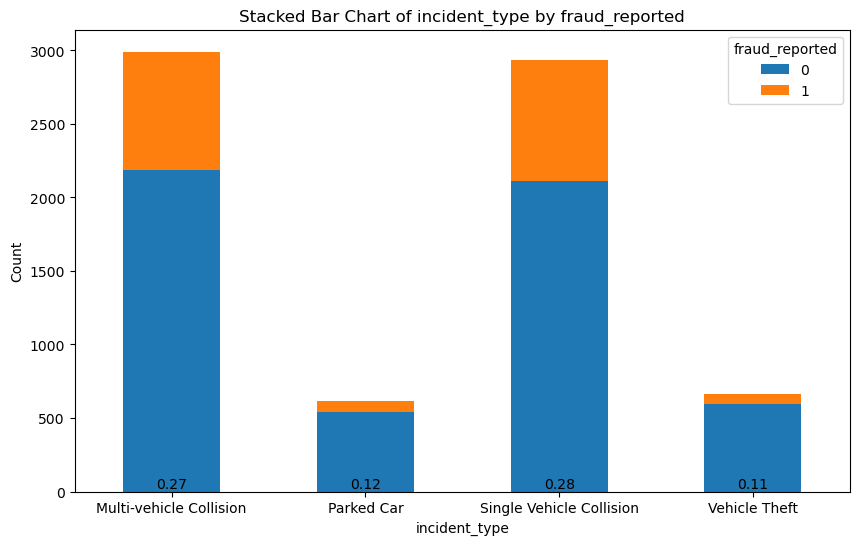

Chi-squared value: 146.65317371539203
P-value: 1.3889461423901129e-31
There is a significant association between the two variables.


In [509]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'incident_type')

## Collision Type

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


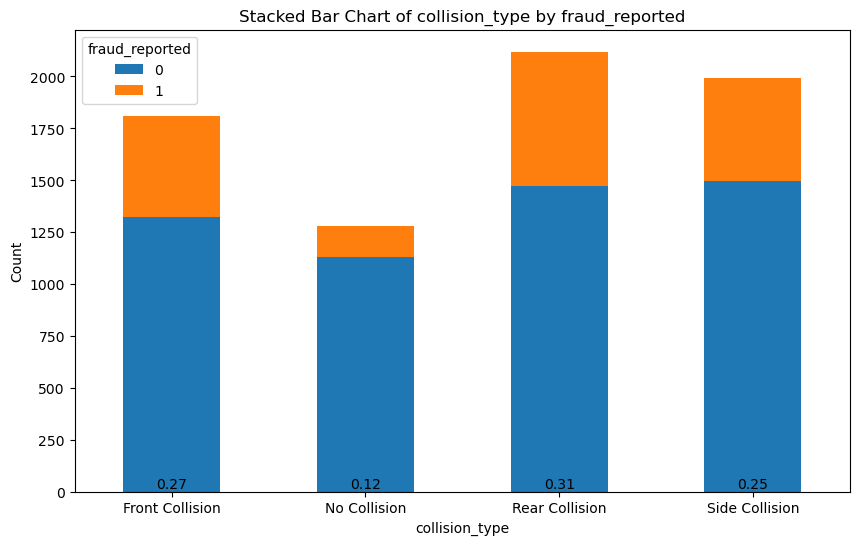

Chi-squared value: 162.95186731374403
P-value: 4.2272934565051213e-35
There is a significant association between the two variables.


In [510]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'collision_type')

## Incident Severity

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


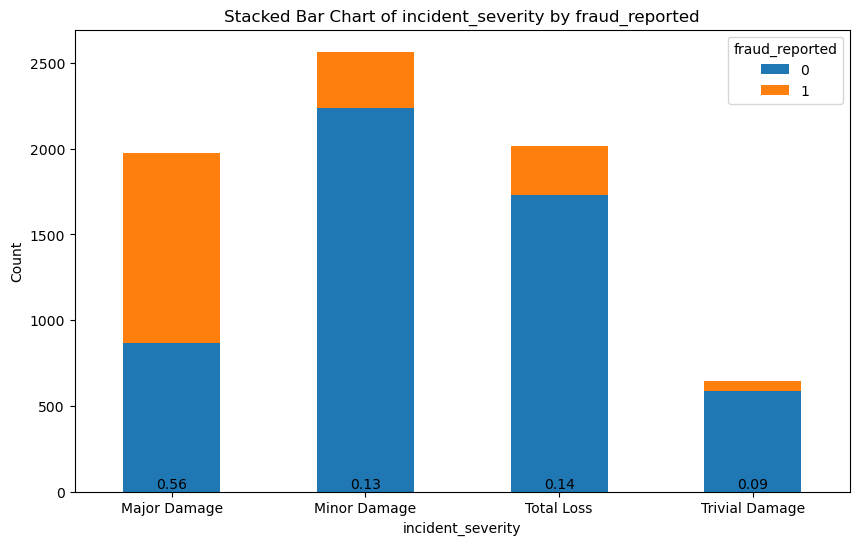

Chi-squared value: 1453.6932025751323
P-value: 0.0
There is a significant association between the two variables.


In [511]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'incident_severity')

## Authorities Contacted

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


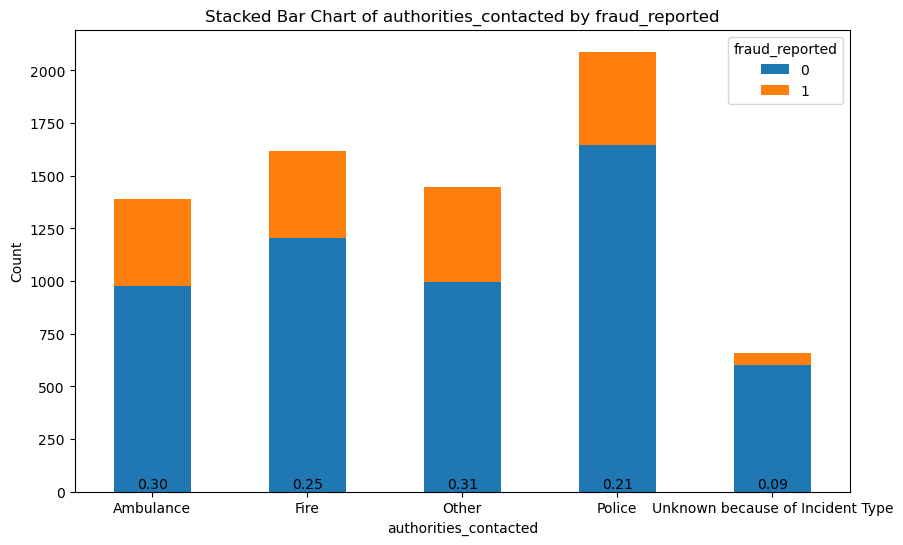

Chi-squared value: 154.9867646718138
P-value: 1.7373395687892724e-32
There is a significant association between the two variables.


In [512]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'authorities_contacted')

## Incident State

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


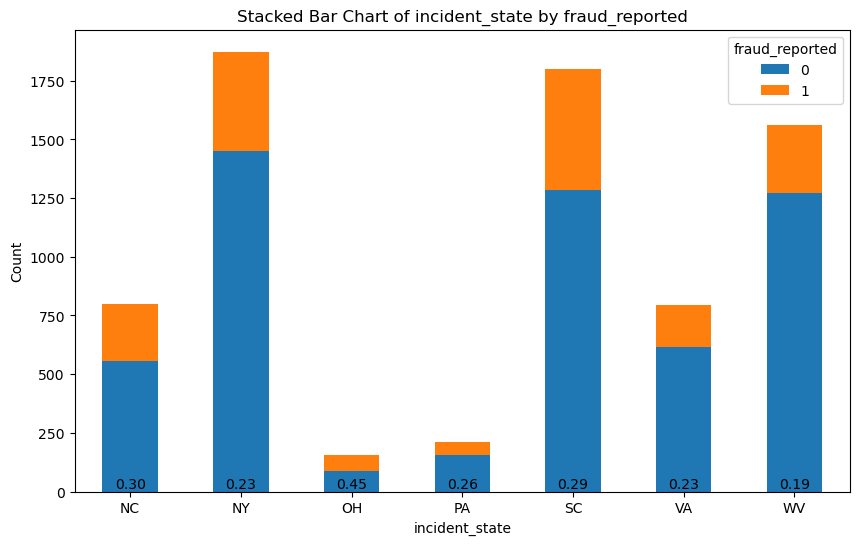

Chi-squared value: 97.93768818012657
P-value: 6.755285942872826e-19
There is a significant association between the two variables.


In [513]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'incident_state')

## Incident City

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


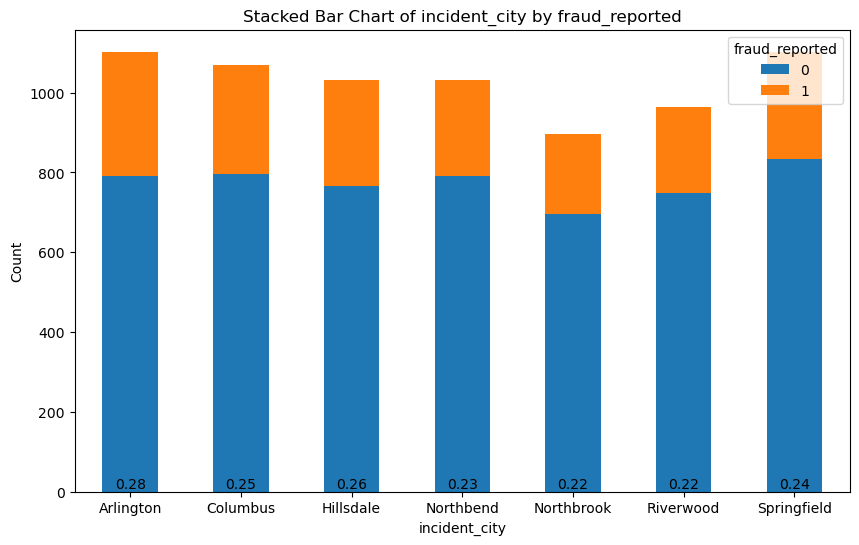

Chi-squared value: 15.03612030137877
P-value: 0.019977633136194464
There is a significant association between the two variables.


In [514]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'incident_city')

## Incident Location

In [515]:
len(train_df['incident_location'].unique())

1000

### Made Requests to External Source to Map Incident Locations to actual addresses

In [516]:
import random
import requests

def get_random_user_agent():
  """
  Returns a randomly selected user agent string for GET requests.
  """
  user_agents = [
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
      "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0",
      "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15",
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Edge/91.0.864.59 Safari/537.36"
  ]
  return random.choice(user_agents)


# Example usage:
headers = {'User-Agent': get_random_user_agent()}
# response = requests.get('https://example.com', headers=headers)

In [517]:
#import time
#from time import sleep
#from random import randint
#from geopy.geocoders import Nominatim
#from geopy.exc import GeocoderTimedOut, GeocoderServiceError

#def get_lat_lon(geolocator, address, sleep_sec, i):
#    try:
#        res = geolocator.geocode(address)
#        print(f'{i} FETCHEDDEDEDEDEDEDEDEDFETCHEDDEDEDEDEDEDEDEDFETCHEDDEDEDEDEDEDEDEDFETCHEDDEDEDEDEDEDEDEDFETCHEDDEDEDEDEDEDEDEDFETCHEDDEDEDEDEDEDEDED')
#        return res
#    except GeocoderTimedOut:
#        print('TIMED OUT: GeocoderTimedOut: Retrying...')
#        sleep(randint(1*100,sleep_sec*100)/100)
#        return get_lat_lon(geolocator, address, sleep_sec)
#    except GeocoderServiceError as e:
#        print('CONNECTION REFUSED: GeocoderServiceError encountered.')
#        print(e)
#       return None
#    except Exception as e:
#        print('ERROR: Terminating due to exception {}'.format(e))
#        return None

#incident_locations = df_insurance['incident_location'].unique()


#ok = {}

# Used a combination of this loop and bottom loop (one or the other)
#i = 0
#for location in incident_locations:
#  if location not in ok or ok[location] is None:
#    user_agent = 'user_me_{}'.format(randint(10000,99999))
#    geolocator = Nominatim(user_agent=user_agent)
#    ok[location] = get_lat_lon(geolocator, location, 1, i)
#    i += 1

# i = 0
# for location in incident_locations:
#   if location not in ok or ok[location] != 'done':
#     url = f"https://nominatim.openstreetmap.org/search?q={'+'.join(location.split(' '))}&format=json&limit=1"
#     headers = {'User-Agent': get_random_user_agent()}
#     r = requests.get("https://nominatim.openstreetmap.org/search?q=2311+4th+St&format=json&limit=1", headers = headers)
#     if len(r.json()) > 0:
#       ok[location] = r.json()[0]
#       print(f'{i} fetched')
#     else:
#       ok[location] = None
#       print(f'{i} FAILED')
#     time.sleep(1)
#     i += 1


In [518]:
#new_ok_df = []
#for i in ok:
#  if ok[i] != 'done':
#   data = ok[i]
#   data['incident_location'] = i
#   new_ok_df.append(data)
#   continue
#

In [519]:
#locations = pd.concat([pd.DataFrame(new_ok_df), ok_df], axis = 0).reset_index().drop(columns = ['index'])
#locations.to_pickle('incident_locations.pkl')

In [520]:
locations = pd.read_pickle('incident_locations.pkl')
#locations = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/incident_locations.pkl')

### Cluster Locations Appropriately

In [521]:
locations = locations[['lat', 'lon', 'class', 'addresstype', 'incident_location']]

In [522]:
locations['lon'] = locations['lon'].astype(float)
locations['lat'] = locations['lat'].astype(float)

train_df = train_df.merge(locations, on='incident_location', how='left')
test_df = test_df.merge(locations, on='incident_location', how='left')

Text(0, 0.5, 'Latitude')

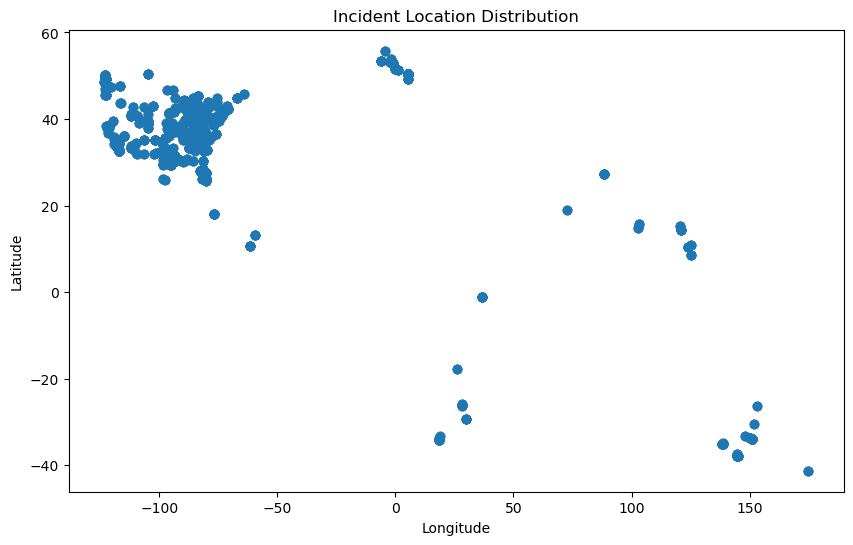

In [523]:
# Plot lat and lon distribution
plt.figure(figsize=(10, 6))
plt.scatter(train_df['lon'].astype(float), train_df['lat'].astype(float), alpha=0.5)
plt.title('Incident Location Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

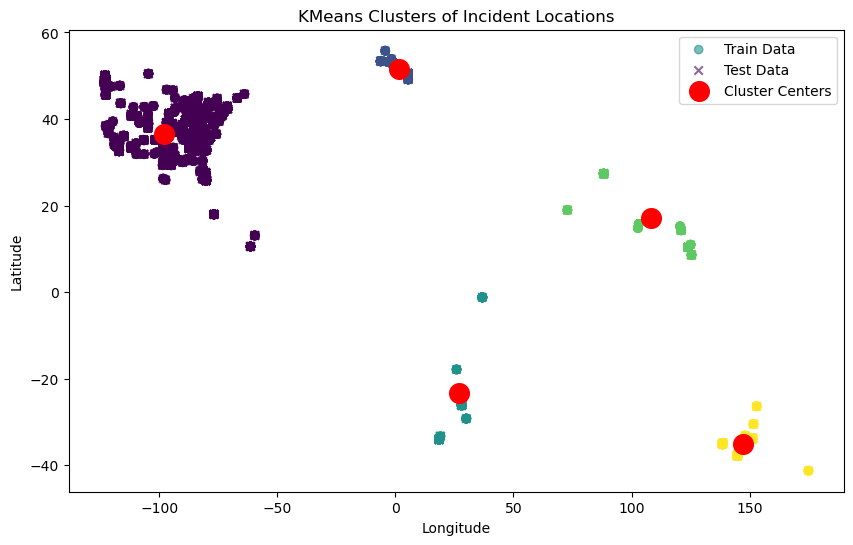

In [524]:
coords_train = train_df[['lat', 'lon']].dropna().astype(float).values
coords_test = test_df[['lat', 'lon']].dropna().astype(float).values

# Apply KMeans clustering
cluster_centroids = [
    [40, -90],
    [50, 0],
    [-20, 30],
    [10, 110],
    [-40, 150]
]
kmeans = KMeans(n_clusters=5, init=cluster_centroids, random_state=42)  # You can change the number of clusters (n_clusters)
kmeans.fit(coords_train)

# Cluster Predictions
train_clusters = kmeans.predict(coords_train)
test_clusters = kmeans.predict(coords_test)

# Add cluster labels to the DataFrame
train_df['cluster'] = np.nan
test_df['cluster'] = np.nan

# Map clusters to original indices (for rows that were not dropped due to NaNs)
train_df.loc[train_df['lat'].notna(), 'cluster'] = train_clusters
test_df.loc[test_df['lat'].notna(), 'cluster'] = test_clusters

# Plot clusters for visualization
plt.figure(figsize=(10, 6))
plt.scatter(train_df['lon'], train_df['lat'], c=train_clusters, cmap='viridis', alpha=0.6, label='Train Data')
plt.scatter(test_df['lon'], test_df['lat'], c=test_clusters, cmap='viridis', marker='x', alpha=0.6, label='Test Data')

# Add cluster centroids to the plot
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], s=200, c='red', label='Cluster Centers')

# Add plot labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clusters of Incident Locations')
plt.legend()
plt.show()

## Incident Hour of the Day

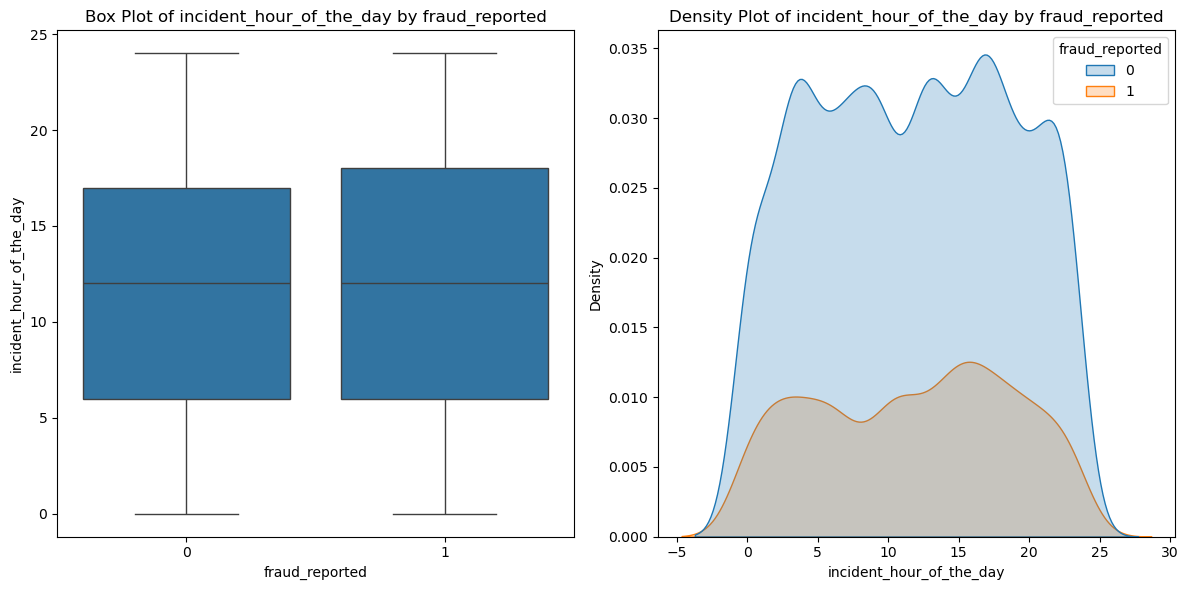

In [525]:
plot_box_density(train_df, 'fraud_reported', 'incident_hour_of_the_day')

## Number of Vehicles involved

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


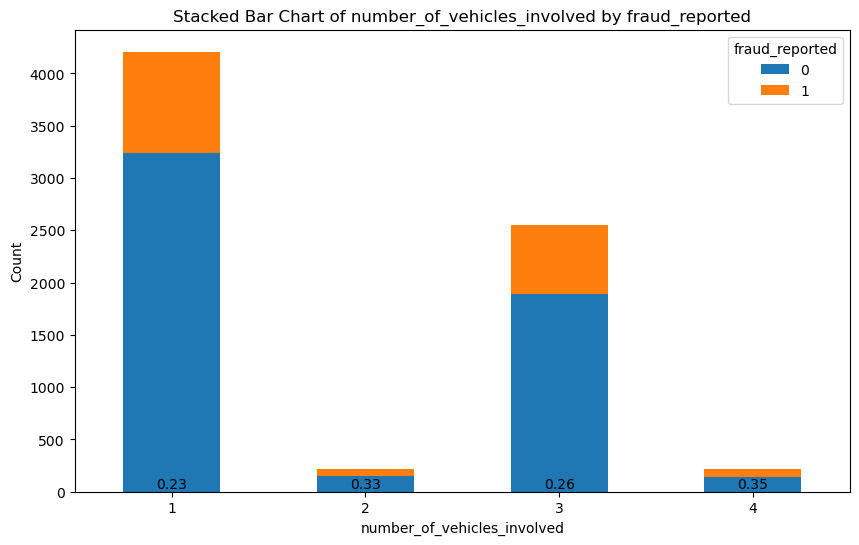

Chi-squared value: 27.672304343624056
P-value: 4.255185526203329e-06
There is a significant association between the two variables.


In [526]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'number_of_vehicles_involved')

## Property Damage

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


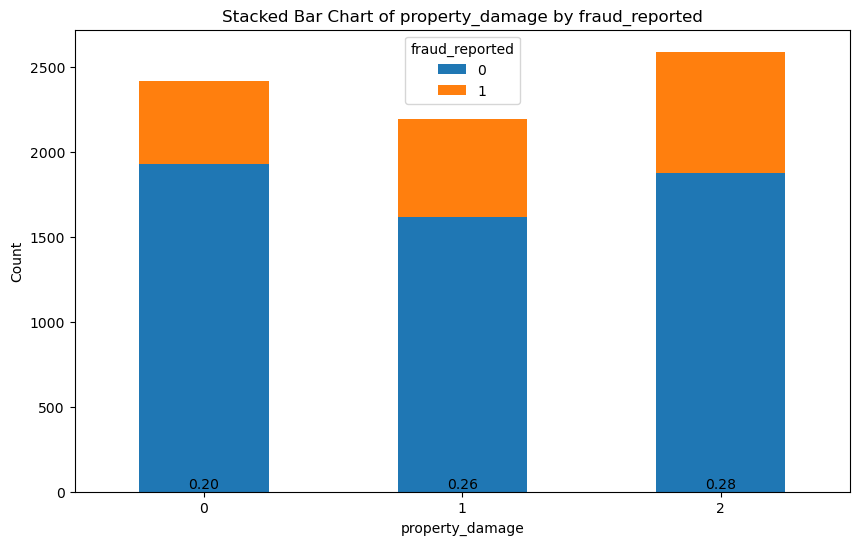

Chi-squared value: 38.52331029539577
P-value: 4.312900679580313e-09
There is a significant association between the two variables.


In [527]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'property_damage')

## Bodily Injuries

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


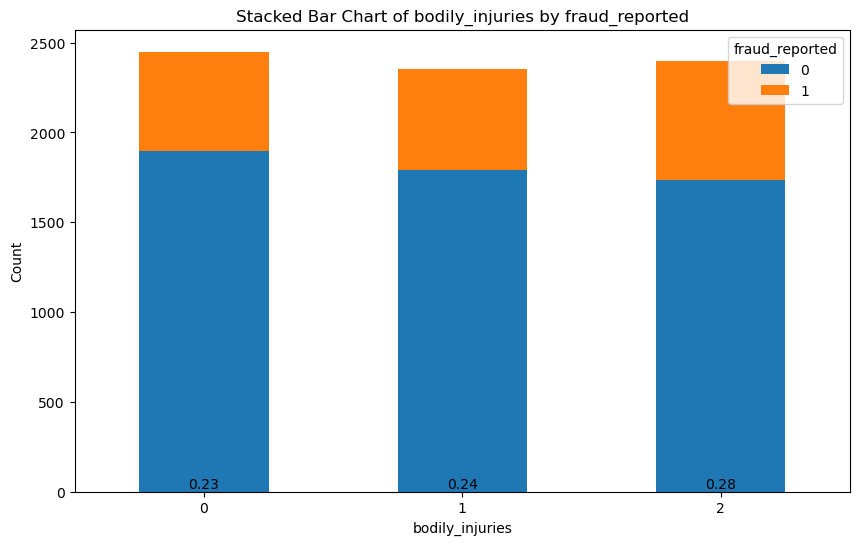

Chi-squared value: 18.271554924374584
P-value: 0.00010774131212222968
There is a significant association between the two variables.


In [528]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'bodily_injuries')

## Witnesses

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


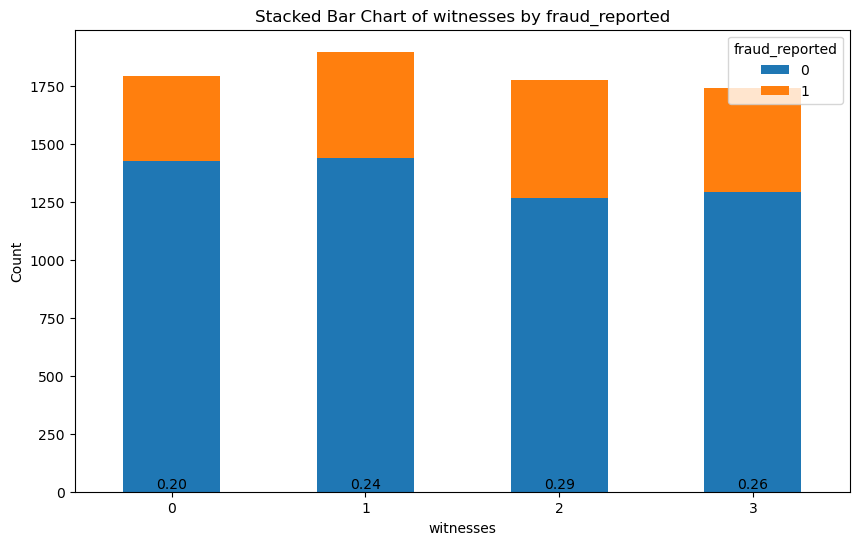

Chi-squared value: 33.356451322511674
P-value: 2.708618191378768e-07
There is a significant association between the two variables.


In [529]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'witnesses')

## Police Report Available

C:\Users\Khant Zaw\AppData\Local\Temp\ipykernel_24004\3139582092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = df.groupby(x_col).apply(lambda x : x[stack_col].sum() / len(x))


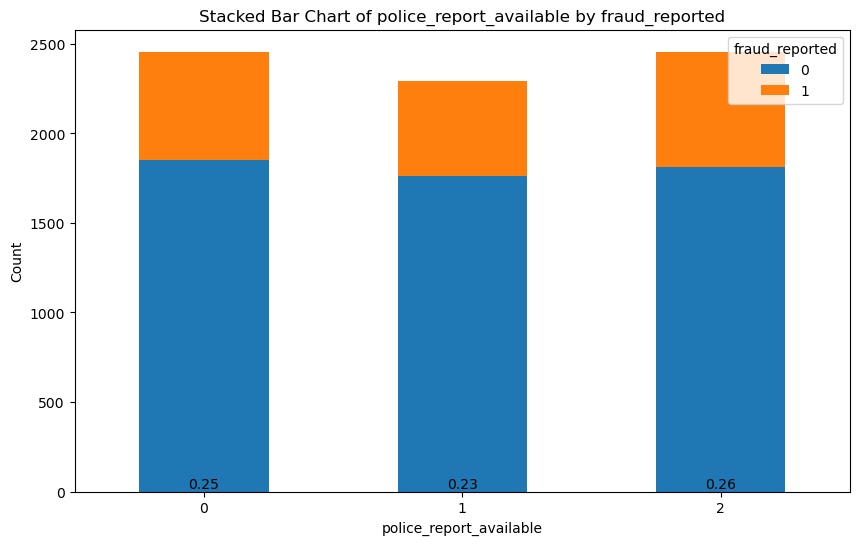

Chi-squared value: 5.96108597536165
P-value: 0.05076526146824897
There is no significant association between the two variables.


In [530]:
plot_stacked_bar_chi2(train_df, 'fraud_reported', 'police_report_available')

## Interaction Variables

In [531]:
def add_interaction_var(df):
  # Claims per Vehicle
  df['claims_per_vehicle'] = (
      df['total_claim_amount'] / df['number_of_vehicles_involved']
  )

  # Age and Claims Interaction
  df['age_claim_interaction'] = (
      df['age'] * df['total_claim_amount']
  )

  # Premium to Deductible Ratio
  df['premium_deductible_ratio'] = (
      df['policy_annual_premium'] / df['policy_deductable']
  )

  # Claims and Witnesses Interaction
  df['claims_witness_interaction'] = (
      df['total_claim_amount'] * df['witnesses']
  )

  # Umbrella Limit Effect
  df['umbrella_claim_interaction'] = (
      df['umbrella_limit'] * df['total_claim_amount']
  )

  # Hourly Risk
  df['hourly_risk'] = (
      df['incident_hour_of_the_day'] * df['total_claim_amount']
  )

  # Capital Gains to Loss Ratio
  df['capital_gain_loss_ratio'] = (
      df['capital-gains'] / (df['capital-loss'] + 1e-9)  # Avoid division by zero
  )

  # Policy Longevity Interaction
  df['policy_longevity_interaction'] = (
      df['months_as_customer'] * df['policy_deductable']
  )

  # Bodily Injuries and Witnesses Interaction
  df['injuries_witnesses_interaction'] = (
      df['bodily_injuries'] * df['witnesses']
  )
  return df

train_df = add_interaction_var(train_df)
test_df = add_interaction_var(test_df)

# Modeling

## Encoding

In [532]:
# Assuming df_insurance is your DataFrame
for column in train_df.iloc[:, :40].columns:
  if train_df[column].dtype == 'category' or train_df[column].dtype == 'object':
    num_distinct_categories = train_df[column].nunique()
    print(f"Column '{column}' has {num_distinct_categories} distinct categories.")

Column 'policy_state' has 3 distinct categories.
Column 'policy_csl' has 3 distinct categories.
Column 'insured_sex' has 2 distinct categories.
Column 'insured_education_level' has 7 distinct categories.
Column 'insured_occupation' has 14 distinct categories.
Column 'insured_hobbies' has 20 distinct categories.
Column 'insured_relationship' has 6 distinct categories.
Column 'incident_type' has 4 distinct categories.
Column 'collision_type' has 4 distinct categories.
Column 'incident_severity' has 4 distinct categories.
Column 'authorities_contacted' has 5 distinct categories.
Column 'incident_state' has 7 distinct categories.
Column 'incident_city' has 7 distinct categories.
Column 'incident_location' has 1000 distinct categories.
Column 'auto_make' has 14 distinct categories.
Column 'auto_model' has 39 distinct categories.


In [533]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def encode_features(df):
  ohe_features = [
      'insured_sex', 'property_damage', 'police_report_available',
      'policy_csl', 'policy_state', 'authorities_contacted', 'collision_type',
      'insured_relationship', 'incident_state', 'incident_city', 'incident_type',
      'class', 'addresstype' # From Incident Location
  ]

  label_encoded_features = [
      'auto_make', 'insured_occupation', 'insured_hobbies', 'auto_model',
  ]

  defined_label_encoded_features = [
      'incident_severity', 'insured_education_level',
  ]

  target = ['fraud_reported']

  # One Hot Encode the ohe_features
  df = pd.get_dummies(df, columns=ohe_features)

  # Label Encode the label_encoded_features
  incident_severity_mapper = {'Trivial Damage': 0, 'Minor Damage': 1, 'Major Damage': 2, 'Total Loss': 3}
  insured_education_level_mapper = {'High School': 0, 'College': 1, 'Associate': 2, 'Masters': 3, 'JD': 4, 'MD': 5, 'PhD': 6}

  df['incident_severity'] = df['incident_severity'].map(incident_severity_mapper)
  df['insured_education_level'] = df['insured_education_level'].map(insured_education_level_mapper)
  for column in label_encoded_features:
    df[column] = LabelEncoder().fit_transform(df[column])

  # Convert Bool to Int types
  for column in df.columns:
    if df[column].dtype == bool:
      df[column] = df[column].astype(int)

  return df

In [534]:
to_delete = ['policy_bind_date', 'incident_date', '_c39', 'incident_location']

train_df = train_df.drop(to_delete, axis=1)
test_df = test_df.drop(to_delete, axis=1)

In [535]:
train_df = encode_features(train_df)
test_df = encode_features(test_df)

X_train, y_train = train_df.drop("fraud_reported", axis=1), train_df["fraud_reported"]
X_test, y_test = test_df.drop("fraud_reported", axis=1), test_df["fraud_reported"]

## Feature Selection

In [536]:
# Compute correlation matrix
correlation_matrix = X_train.corr()

# Filter correlations greater than 0.80
high_correlations = correlation_matrix[(correlation_matrix > 0.90) & (correlation_matrix < 1.0)]

for column in high_correlations:
    correlated_features = high_correlations[column].dropna()
    for index, correlation in correlated_features.items():
        print(f"{column} - {index}: {correlation:.2f}")

months_as_customer - age: 0.92
age - months_as_customer: 0.92
policy_deductable - policy_deductable_bin: 0.98
capital-gains - capital_gains_bin: 0.93
capital-loss - capital_loss_bin: 0.92
number_of_vehicles_involved - incident_type_Multi-vehicle Collision: 0.97
total_claim_amount - vehicle_claim: 0.98
vehicle_claim - total_claim_amount: 0.98
total_claim_amount_bin - injury_claim_bin: 0.92
total_claim_amount_bin - property_claim_bin: 0.95
injury_claim_bin - total_claim_amount_bin: 0.92
injury_claim_bin - vehicle_claim_bin: 0.92
property_claim_bin - total_claim_amount_bin: 0.95
property_claim_bin - vehicle_claim_bin: 0.95
vehicle_claim_bin - injury_claim_bin: 0.92
vehicle_claim_bin - property_claim_bin: 0.95
policy_deductable_bin - policy_deductable: 0.98
capital_gains_bin - capital-gains: 0.93
capital_loss_bin - capital-loss: 0.92
lon - cluster: 0.96
cluster - lon: 0.96
incident_type_Multi-vehicle Collision - number_of_vehicles_involved: 0.97
class_place - addresstype_place: 0.90
addres

In [537]:
columns_to_drop = [
    'age',
    'policy_deductable',
    'capital-gains',
    'capital-loss',
    'incident_type_Multi-vehicle Collision',
    'total_claim_amount',
    'total_claim_amount_bin',
    'injury_claim_bin',
    'lon',
    'property_claim_bin',
    'hourly_risk',
    'class_place'
]
X_train.drop(columns=columns_to_drop, errors='ignore', inplace=True)
X_test.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [538]:
ohe_features = {
  'insured_sex': ['insured_sex_FEMALE', 'insured_sex_MALE'],
  'property_damage': ['property_damage_0.0', 'property_damage_0.302', 'property_damage_1.0'],
  'police_report': ['police_report_available_0.0', 'police_report_available_0.314', 'police_report_available_1.0'],
  'policy_csl': ['policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000'],
  'policy_state': ['policy_state_IL', 'policy_state_IN', 'policy_state_OH'],
  'authorities_contacted': ['authorities_contacted_Police', 'authorities_contacted_Fire', 'authorities_contacted_Unknown because of Incident Type', 'authorities_contacted_Other', 'authorities_contacted_Ambulance'],
  'collision_type': ['collision_type_Front Collision', 'collision_type_No Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision'],
  'insured_relationship': ['insured_relationship_husband', 'insured_relationship_not-in-family', 'insured_relationship_other-relative', 'insured_relationship_own-child', 'insured_relationship_unmarried', 'insured_relationship_wife'],
  'incident_state': ['incident_state_NC', 'incident_state_NY', 'incident_state_OH', 'incident_state_PA', 'incident_state_SC', 'incident_state_VA', 'incident_state_WV'],
  'incident_city': ['incident_city_Arlington', 'incident_city_Columbus', 'incident_city_Hillsdale', 'incident_city_Northbend', 'incident_city_Northbrook', 'incident_city_Riverwood', 'incident_city_Springfield'],
  'incident_type': ['incident_type_Single Vehicle Collision', 'incident_type_Parked Car', 'incident_type_Vehicle Theft'],
  'class': ['class_amenity', 'class_boundary', 'class_building', 'class_highway', 'class_landuse', 'class_shop', 'class_tourism'],
  'addresstype': ['addresstype_amenity', 'addresstype_building', 'addresstype_city', 'addresstype_hamlet', 'addresstype_neighbourhood', 'addresstype_place', 'addresstype_residential', 'addresstype_road', 'addresstype_shop', 'addresstype_tourism', 'addresstype_town', 'addresstype_village']
}

def plot_feature_impt(perm_importance, title):
  # Get feature importance scores
  feature_names = X_train.columns
  importance_scores = perm_importance.importances_mean

  # Aggregate importance scores for categorical groups
  aggregated_importance = defaultdict(float)
  columns_of_important_features = defaultdict(list)

  # Sum importance scores for one-hot encoded groups
  for original_feature, one_hot_features in ohe_features.items():
      for col in one_hot_features:
          if col in feature_names:
              col_index = feature_names.get_loc(col)
              aggregated_importance[original_feature] += importance_scores[col_index]
              columns_of_important_features[original_feature].append(col)

  # Add non-categorical features to the aggregated importance dictionary
  for feature, score in zip(feature_names, importance_scores):
      if feature not in [col for sublist in ohe_features.values() for col in sublist]:
          aggregated_importance[feature] = score
          columns_of_important_features[feature].append(feature)

  # Sort aggregated features by importance
  sorted_aggregated = sorted(aggregated_importance.items(), key=lambda x: x[1], reverse=True)

  # Extract sorted feature names, their scores, and associated columns
  sorted_features = [item[0] for item in sorted_aggregated]
  sorted_scores = [item[1] for item in sorted_aggregated]
  sorted_columns = [columns_of_important_features[feature] for feature in sorted_features]

  # Display top features with their associated columns
  print("Top Features and their Associated Columns:")
  for i in range(len(sorted_features[:18])):
      print(f"Feature: {sorted_features[i]}, Score: {sorted_scores[i]:.4f}, Columns: {sorted_columns[i]}")

  # Plot top 18 aggregated feature importances
  plt.figure(figsize=(10, 6))
  plt.bar(range(18), sorted_scores[:18], color='skyblue')
  plt.xticks(range(18), sorted_features[:18], rotation=45, ha='right')
  plt.xlabel('Feature')
  plt.ylabel('Aggregated Importance Score')
  plt.title(title)
  plt.tight_layout()
  plt.show()

  return sorted_features[:20]

Top Features and their Associated Columns:
Feature: incident_severity, Score: 0.0375, Columns: ['incident_severity']
Feature: insured_hobbies, Score: 0.0031, Columns: ['insured_hobbies']
Feature: property_claim, Score: 0.0005, Columns: ['property_claim']
Feature: lat, Score: 0.0004, Columns: ['lat']
Feature: claims_witness_interaction, Score: 0.0004, Columns: ['claims_witness_interaction']
Feature: vehicle_claim, Score: 0.0004, Columns: ['vehicle_claim']
Feature: months_as_customer, Score: 0.0003, Columns: ['months_as_customer']
Feature: age_claim_interaction, Score: 0.0002, Columns: ['age_claim_interaction']
Feature: claims_per_vehicle, Score: 0.0001, Columns: ['claims_per_vehicle']
Feature: insured_occupation, Score: 0.0000, Columns: ['insured_occupation']
Feature: insured_sex, Score: 0.0000, Columns: ['insured_sex_FEMALE', 'insured_sex_MALE']
Feature: policy_csl, Score: 0.0000, Columns: ['policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000']
Feature: policy_state, Score:

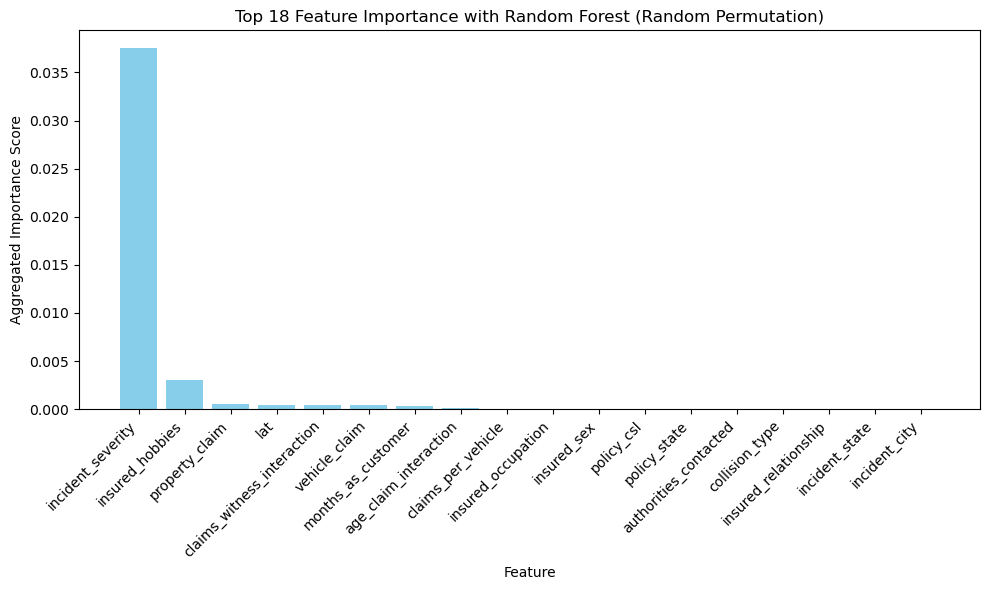

In [539]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

top_rf_perm = plot_feature_impt(perm_importance, 'Top 18 Feature Importance with Random Forest (Random Permutation)')

Top Features and their Associated Columns:
Feature: incident_severity, Score: 0.1851, Columns: ['incident_severity']
Feature: insured_hobbies, Score: 0.0844, Columns: ['insured_hobbies']
Feature: difference_bind_date_incident, Score: 0.0323, Columns: ['difference_bind_date_incident']
Feature: insured_occupation, Score: 0.0020, Columns: ['insured_occupation']
Feature: umbrella_limit, Score: 0.0018, Columns: ['umbrella_limit']
Feature: property_claim, Score: 0.0014, Columns: ['property_claim']
Feature: lat, Score: 0.0012, Columns: ['lat']
Feature: auto_year, Score: 0.0012, Columns: ['auto_year']
Feature: policy_state, Score: 0.0007, Columns: ['policy_state_IL', 'policy_state_IN', 'policy_state_OH']
Feature: policy_csl, Score: 0.0003, Columns: ['policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000']
Feature: addresstype, Score: 0.0001, Columns: ['addresstype_amenity', 'addresstype_building', 'addresstype_city', 'addresstype_hamlet', 'addresstype_neighbourhood', 'addresstype_pla

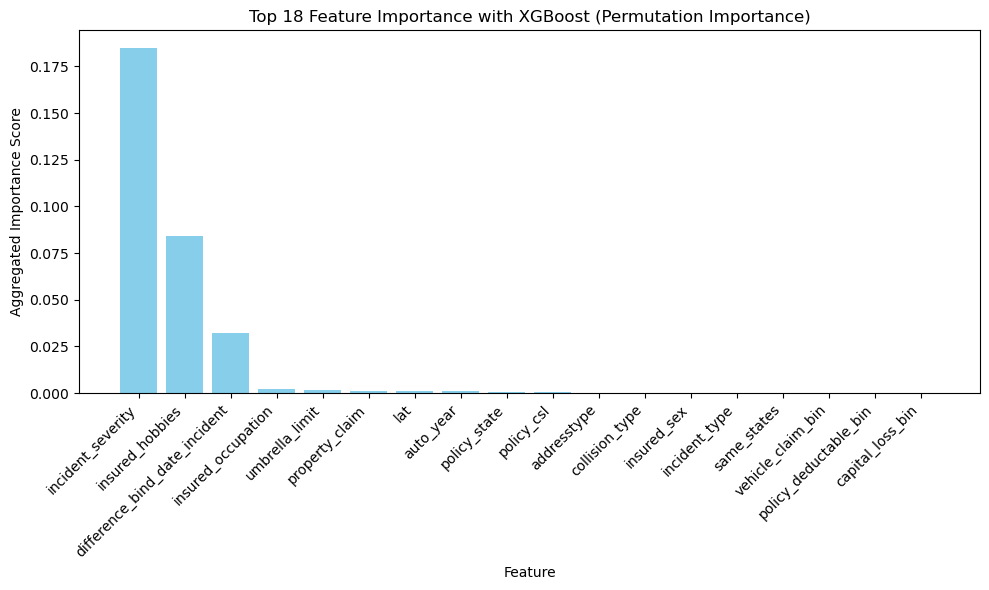

In [540]:
# Training the XGBoost Classifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Computing Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

top_xgb_perm = plot_feature_impt(perm_importance, 'Top 18 Feature Importance with XGBoost (Permutation Importance)')

In [541]:
repeat_top = list(set(top_rf_perm) & set(top_xgb_perm))

repeat_top = [ohe_features[i] if i in ohe_features else i for i in repeat_top]
repeat_top_flat = []
for i in repeat_top:
  if isinstance(i, list):
    repeat_top_flat.extend(i)
  else:
    repeat_top_flat.append(i)
repeat_top = repeat_top_flat
repeat_top

['insured_sex_FEMALE',
 'insured_sex_MALE',
 'collision_type_Front Collision',
 'collision_type_No Collision',
 'collision_type_Rear Collision',
 'collision_type_Side Collision',
 'policy_csl_100/300',
 'policy_csl_250/500',
 'policy_csl_500/1000',
 'insured_occupation',
 'incident_type_Single Vehicle Collision',
 'incident_type_Parked Car',
 'incident_type_Vehicle Theft',
 'policy_state_IL',
 'policy_state_IN',
 'policy_state_OH',
 'lat',
 'incident_severity',
 'property_claim',
 'insured_hobbies']

In [542]:
list(set(top_rf_perm) & set(top_xgb_perm))

['insured_sex',
 'collision_type',
 'policy_csl',
 'insured_occupation',
 'incident_type',
 'policy_state',
 'lat',
 'incident_severity',
 'property_claim',
 'insured_hobbies']

In [543]:
X_train = X_train[repeat_top]
X_test = X_test[repeat_top]

## RFECV

In [544]:
def map_ohe_to_original(feature_name):
  for i in ohe_features:
    if feature_name in ohe_features[i]:
      return i
  return feature_name

def map_original_to_ohe(feature_name):
  if feature_name in ohe_features:
    return ohe_features[feature_name]
  return [feature_name]

In [545]:
def get_top_features(estimator, estimator_name):
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  rfecv = RFECV(estimator = estimator, step=1, cv=cv, scoring='accuracy', n_jobs=-1)
  rfecv.fit(X_train, y_train)

  top_features = X_train.columns[rfecv.support_]
  top_features = [map_original_to_ohe(j) for j in set([map_ohe_to_original(i) for i in top_features])]
  top_features = [j for sublist in top_features for j in sublist]
  print(f"Optimal number of features from repeat_top for {estimator_name}:", len(top_features))
  print(f"Selected features from repeat_top for {estimator_name}:", top_features)

  return top_features

In [546]:
rf_estimator = RandomForestClassifier(random_state=42)
rf_top_features = get_top_features(rf_estimator, 'RF')

Optimal number of features from repeat_top for RF: 4
Selected features from repeat_top for RF: ['insured_hobbies', 'lat', 'incident_severity', 'property_claim']


In [547]:
xgb_estimator = XGBClassifier(random_state=42)

xgb_top_features = get_top_features(xgb_estimator, 'XGB')

Optimal number of features from repeat_top for XGB: 19
Selected features from repeat_top for XGB: ['insured_sex_FEMALE', 'insured_sex_MALE', 'collision_type_Front Collision', 'collision_type_No Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000', 'insured_occupation', 'incident_type_Single Vehicle Collision', 'incident_type_Parked Car', 'incident_type_Vehicle Theft', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH', 'lat', 'incident_severity', 'insured_hobbies']


In [548]:
X_train_xgb_rfecv, X_test_xgb_rfecv = X_train[xgb_top_features], X_test[xgb_top_features]

## Functions

In [581]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def train_random_forest(X_train, y_train, X_test, y_test, params = {}):
  # Train a Random Forest Classifier
  rf_classifier = RandomForestClassifier(
      **params,
      class_weight='balanced',
      random_state=42
  )
  rf_classifier.fit(X_train, y_train)

  # Make predictions on the testing data
  y_pred = rf_classifier.predict(X_test)
  y_pred_proba = rf_classifier.predict_proba(X_test)

  # Evaluate the model's accuracy
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
  print(f"Accuracy: {accuracy}")
  print(f"ROC-AUC: {roc_auc}")

  print(classification_report(y_test, y_pred, digits = 4))

  return rf_classifier

def train_xgb(X_train, y_train, X_test, y_test, params = {}):
  model = XGBClassifier(
      **params,
      scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
      random_state=42
  )

  # Train the model
  model.fit(X_train, y_train, verbose = False)

  # Make predictions on the test set
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  auc_roc = roc_auc_score(y_test, y_pred_proba)
  print(f"Accuracy: {accuracy}")
  print(f"ROC-AUC: {auc_roc}")

  print(classification_report(y_test, y_pred, digits = 4))

  return model

def train_SVM_model(X_train, y_train, X_test, y_test, params = {}):
  # Create an SVM model
  model = SVC(
      **params,
      probability=True,
      class_weight='balanced',
      random_state=42
  ) 

  # Train the model
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("ROC-AUC:", roc_auc)
  print(classification_report(y_test, y_pred, digits = 4))
  print(confusion_matrix(y_test, y_pred))

  return model

def train_stacked(X_train, y_train, X_test, y_test, rf_params = {}, xgb_params = {}):
  # Train the model
  rf_classifier = RandomForestClassifier(
      **rf_params,
      # n_estimators=300,
      # min_samples_split = 5,
      random_state=42
  )
  xgb_classifier = XGBClassifier(
      **xgb_params,
      random_state=42
  )

  estimators = [
      ('rf', rf_classifier),
      ('xgb', xgb_classifier)
  ]

  stacked_model = StackingClassifier(
      estimators=estimators,
      final_estimator=LogisticRegression(random_state=42)
  )

  stacked_model.fit(X_train, y_train)
  y_pred = stacked_model.predict(X_test)

  y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred_proba)

  print("Accuracy:", accuracy)
  print("ROC-AUC:", roc_auc)
  print(classification_report(y_test, y_pred, digits = 4))
  print(confusion_matrix(y_test, y_pred))

In [550]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

from hyperopt import space_eval

def optimize_hyperparams(X_train, y_train, X_test, y_test, model_type, max_evals=50):
    """
    Perform hyperparameter tuning for Random Forest, XGBoost, or SVM using Hyperopt.

    Parameters:
        X: Features (numpy array or DataFrame).
        y: Target (numpy array or Series).
        model_type: 'random_forest', 'xgboost', or 'svm'.
        max_evals: Number of evaluations for Hyperopt.

    Returns:
        Best hyperparameters and associated trials.
    """
    # Define the objective function
    def objective(params):
        if model_type == 'random_forest':
            model = RandomForestClassifier(**params, random_state=42)
        elif model_type == 'xgboost':
            model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        elif model_type == 'svm':
            model = SVC(**params, probability=True, random_state=42)
        else:
            raise ValueError("Unsupported model_type. Choose 'random_forest', 'xgboost', or 'svm'.")

        model.fit(X_train, y_train)

        # Validate on test data
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(auc_score)
        f1 = f1_score(y_test, y_pred)

        return {'loss': -f1, 'status': STATUS_OK}

    # Define the hyperparameter space
    if model_type == 'random_forest':
        param_space = {
            'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500]),
            'max_depth': hp.choice('max_depth', [5, 10, 20, None]),
            'min_samples_split': hp.choice('min_samples_split', [3, 5, 7])
        }
    elif model_type == 'xgboost':
        param_space = {
            'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500]),
            'max_depth': hp.choice('max_depth', [3, 6, 10, 15]),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
            'subsample': hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
            'gamma': hp.uniform('gamma', 0, 5),
        }
    elif model_type == 'svm':
        param_space = {
            'C': hp.loguniform('C', np.log(0.01), np.log(10)),
            'kernel': hp.choice('kernel', ['linear', 'rbf']),
            'gamma': hp.choice('gamma', ['scale'])
        }

    else:
        raise ValueError("Unsupported model_type. Choose 'random_forest', 'xgboost', or 'svm'.")

    # Hyperopt optimization
    trials = Trials()
    best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    return space_eval(param_space, best), trials

# Define a custom stacking model
class StackedModel:
    def __init__(self, rf_params=None, xgb_params=None, lr_params=None):
        self.rf_params = rf_params if rf_params else {}
        self.xgb_params = xgb_params if xgb_params else {}
        self.lr_params = lr_params if lr_params else {}

        self.rf = RandomForestClassifier(**self.rf_params, random_state=42)
        self.xgb = XGBClassifier(**self.xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        self.lr = LogisticRegression(**self.lr_params, random_state=42)

    def fit(self, X_train, y_train):
        # Train base models
        self.rf.fit(X_train, y_train)
        self.xgb.fit(X_train, y_train)

        # Create meta-features
        rf_preds = self.rf.predict_proba(X_train)[:, 1].reshape(-1, 1)
        xgb_preds = self.xgb.predict_proba(X_train)[:, 1].reshape(-1, 1)
        meta_features = np.hstack([rf_preds, xgb_preds])

        # Train meta-classifier
        self.lr.fit(meta_features, y_train)

    def predict(self, X):
        # Generate meta-features
        rf_preds = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        xgb_preds = self.xgb.predict_proba(X)[:, 1].reshape(-1, 1)
        meta_features = np.hstack([rf_preds, xgb_preds])

        return self.lr.predict(meta_features)

    def predict_proba(self, X):
        # Generate meta-features
        rf_preds = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        xgb_preds = self.xgb.predict_proba(X)[:, 1].reshape(-1, 1)
        meta_features = np.hstack([rf_preds, xgb_preds])

        return self.lr.predict_proba(meta_features)


# Define the objective function for Hyperopt
def optimize_stacked_model(X_train, y_train, X_test, y_test, max_evals=50):
    def objective(params):
        # Unpack parameters
        rf_params = {
            'n_estimators': int(params['rf_n_estimators']),
            'max_depth': params['rf_max_depth'],
            'min_samples_split': params['rf_min_samples_split']
        }

        xgb_params = {
            'n_estimators': int(params['xgb_n_estimators']),
            'max_depth': int(params['xgb_max_depth']),
            'learning_rate': params['xgb_learning_rate'],
            'subsample': params['xgb_subsample'],
            'colsample_bytree': params['xgb_colsample_bytree'],
        }

        lr_params = {
            'C': params['lr_C'],
            'penalty': params['lr_penalty']
        }

        # Initialize and evaluate the stacked model

        model = StackedModel(rf_params=rf_params, xgb_params=xgb_params, lr_params=lr_params)
        model.fit(X_train, y_train)

        # Validate on test data
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        return {'loss': -auc_score, 'status': STATUS_OK}

    # Define the hyperparameter space
    param_space = {
        'rf_n_estimators': hp.choice('rf_n_estimators', [100, 200, 300, 500]),
        'rf_max_depth': hp.choice('rf_max_depth', [5, 10, 20, None]),
        'rf_min_samples_split': hp.choice('rf_min_samples_split', [3, 5, 7]),

        'xgb_n_estimators': hp.choice('xgb_n_estimators', [100, 200, 300, 500]),
        'xgb_max_depth': hp.choice('xgb_max_depth', [3, 6, 10, 15]),
        'xgb_learning_rate': hp.uniform('xgb_learning_rate', 0.01, 0.3),
        'xgb_subsample': hp.uniform('xgb_subsample', 0.5, 1),
        'xgb_colsample_bytree': hp.uniform('xgb_colsample_bytree', 0.5, 1),

        'lr_C': hp.loguniform('lr_C', np.log(0.01), np.log(10)),
        'lr_penalty': hp.choice('lr_penalty', ['l2']),
    }

    # Perform optimization
    trials = Trials()
    best = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )

    return space_eval(param_space, best), trials

In [551]:
def compare_data(model, datasets):
  global train_random_forest
  global train_catboost
  global train_SVM_model

  train_model_fns = {
      'rf': train_random_forest,
      'xgb': train_xgb,
      'svm': train_SVM_model,
      'stacked': train_stacked
  }
  train_model_fn = train_model_fns[model]

  models = []
  for dataset in datasets:
    model = train_model_fn(*dataset)
    models.append(model)
  return models

## Models

### Random Forest

In [595]:
datasets = [
    [X_train, y_train, X_test, y_test], # Top Features
    [X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test] #RFECV
]

rf_models = compare_data('rf', datasets)

Accuracy: 0.9144444444444444
ROC-AUC: 0.9280484265516811
              precision    recall  f1-score   support

           0     0.9458    0.9402    0.9430      1355
           1     0.8212    0.8360    0.8285       445

    accuracy                         0.9144      1800
   macro avg     0.8835    0.8881    0.8858      1800
weighted avg     0.9150    0.9144    0.9147      1800

Accuracy: 0.9533333333333334
ROC-AUC: 0.9275666487001949
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800



#### Hyperparameter Tuning to get best RF Model

In [596]:
x_train_small, x_val, y_train_small, y_val = train_test_split(X_train_xgb_rfecv, y_train, test_size=0.2, random_state=42)

best_rf_params, trials = optimize_hyperparams(x_train_small, y_train_small, x_val, y_val, 'random_forest', 30)

0.927115031453394                                     
0.9274937478572625                                                               
0.9277209776995836                                                               
0.9232215610557284                                                               
0.9246806158327376                                                               
0.9265064275482299                                                               
0.927115031453394                                                                
0.9242381156134807                                                               
0.9280026895508822                                                               
0.9260692426469219                                                               
0.8817740405186687                                                                
0.8823029146545973                                                                
0.9279176444636976                       

In [597]:
rf_model = train_random_forest(X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test, best_rf_params)

y_pred = rf_model.predict(X_test_xgb_rfecv)
y_pred_proba = rf_model.predict_proba(X_test_xgb_rfecv)[:, 1]

rf_rfecv_precision = precision_score(y_test, y_pred)
rf_rfecv_accuracy = accuracy_score(y_test, y_pred)
rf_rfecv_recall = recall_score(y_test, y_pred)
rf_rfecv_f1 = f1_score(y_test, y_pred)
rf_rfecv_auc = roc_auc_score(y_test, y_pred_proba)

Accuracy: 0.9533333333333334
ROC-AUC: 0.9268618101911354
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800



### XGBoost

Overall, RFECV + Smote seems to give the best balance of results:
97.5% AUROC with reasonably high recall and f1-score


In [592]:
datasets = [
    [X_train, y_train, X_test, y_test], # Top Features
    [X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test], # RFECV
]

xgb_models = compare_data('xgb', datasets)

xgb_precision = precision_score(y_test, xgb_models[0].predict(X_test))
xgb_accuracy = accuracy_score(y_test, xgb_models[0].predict(X_test))
xgb_recall = recall_score(y_test, xgb_models[0].predict(X_test))
xgb_f1 = f1_score(y_test, xgb_models[0].predict(X_test))
xgb_auc = roc_auc_score(y_test, xgb_models[0].predict_proba(X_test)[:, 1])

Accuracy: 0.9383333333333334
ROC-AUC: 0.9305219951075914
              precision    recall  f1-score   support

           0     0.9712    0.9461    0.9585      1355
           1     0.8479    0.9146    0.8800       445

    accuracy                         0.9383      1800
   macro avg     0.9096    0.9304    0.9193      1800
weighted avg     0.9407    0.9383    0.9391      1800

Accuracy: 0.9533333333333334
ROC-AUC: 0.9289489613997264
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800



In [593]:
x_train_small, x_val, y_train_small, y_val = train_test_split(X_train_xgb_rfecv, y_train, test_size=0.2, random_state=42)

best_xgb_params, trials = optimize_hyperparams(x_train_small, y_train_small, x_val, y_val, 'xgboost', 30)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:25] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9268040853533757                                    
  3%|▎         | 1/30 [00:00<00:10,  2.86trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9263097607841158                                                               
0.9035628576212358                                                               
 10%|█         | 3/30 [00:00<00:07,  3.77trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.935417558089781                                                                
0.9242925976224583                                                               
 17%|█▋        | 5/30 [00:01<00:05,  4.57trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9231086105493116                                                               
0.8894307560242485                                                               
 23%|██▎       | 7/30 [00:01<00:04,  4.89trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9219910649505276                                                               
 27%|██▋       | 8/30 [00:01<00:04,  5.10trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9201439919632394                                                               
 30%|███       | 9/30 [00:02<00:04,  4.89trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.933551881489671                                                                
 33%|███▎      | 10/30 [00:02<00:04,  4.40trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.92536762067765                                                                  
0.9302484113843479                                                                
 37%|███▋      | 11/30 [00:02<00:04,  4.27trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 12/30 [00:02<00:04,  4.43trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9306125106638565                                                                
 43%|████▎     | 13/30 [00:03<00:04,  4.15trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9289169242381157                                                                
 47%|████▋     | 14/30 [00:03<00:04,  3.92trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:29] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.933283457933245                                                                 
0.926826675454659                                                                 
 53%|█████▎    | 16/30 [00:03<00:03,  4.25trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:29] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:29] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9281594914303786                                                                
 57%|█████▋    | 17/30 [00:04<00:03,  3.60trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:29] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.929408591148401                                                                 
0.9164843955553312                                                                
 63%|██████▎   | 19/30 [00:04<00:02,  4.23trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9322549439101073                                                                
 67%|██████▋   | 20/30 [00:05<00:02,  3.49trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9267057519713185                                                                
 70%|███████   | 21/30 [00:05<00:03,  2.84trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:31] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9241171921301403                                                                
 73%|███████▎  | 22/30 [00:05<00:03,  2.58trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:31] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9230939934249516                                                                
0.9279787706201115                                                                
 80%|████████  | 24/30 [00:06<00:01,  3.07trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:32] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:32] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9256612919943339                                                                
0.9245184986352921                                                                
 87%|████████▋ | 26/30 [00:07<00:01,  3.65trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:32] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:32] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9266127339072106                                                                
0.9278100092752297                                                                
 93%|█████████▎| 28/30 [00:07<00:00,  4.46trial/s, best loss: -0.9156976744186046]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:33] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:33] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9247709762378711                                                                
0.9306550332074488                                                                
100%|██████████| 30/30 [00:07<00:00,  3.90trial/s, best loss: -0.9156976744186046]


C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:33] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



In [594]:
model = train_xgb(X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test, best_xgb_params)

xgb_rfecv_precision = precision_score(y_test, model.predict(X_test_xgb_rfecv))
xgb_rfecv_accuracy = accuracy_score(y_test, model.predict(X_test_xgb_rfecv))
xgb_rfecv_recall = recall_score(y_test, model.predict(X_test_xgb_rfecv))
xgb_rfecv_f1 = f1_score(y_test, model.predict(X_test_xgb_rfecv))
xgb_rfecv_auc = roc_auc_score(y_test, model.predict_proba(X_test_xgb_rfecv)[:, 1])

Accuracy: 0.9533333333333334
ROC-AUC: 0.9274580206476224
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800



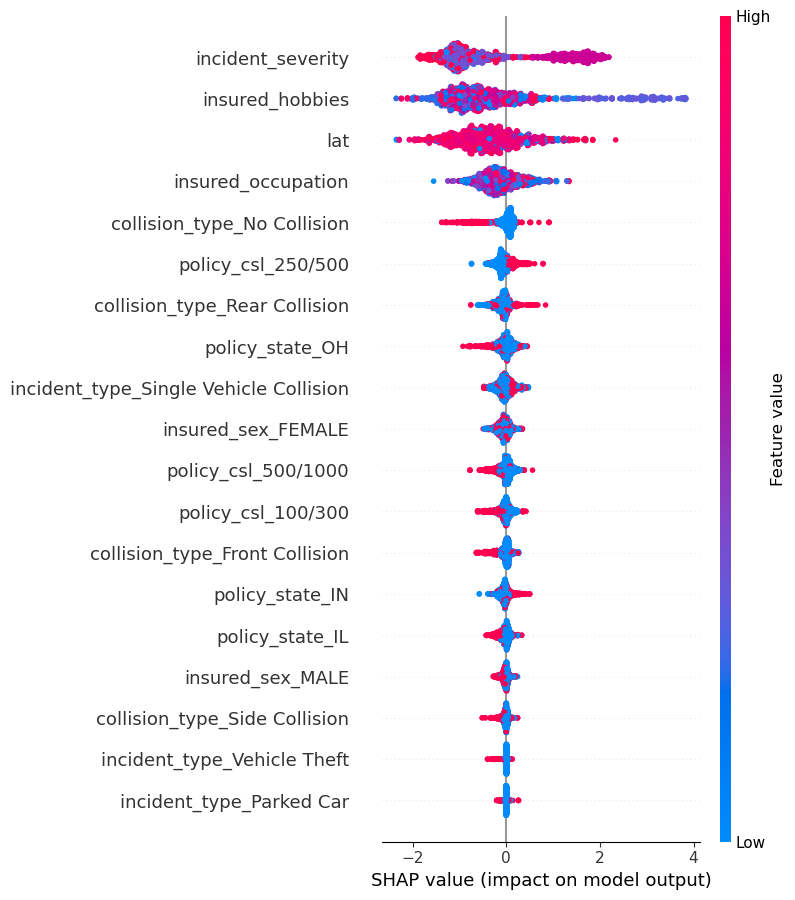

In [558]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_xgb_rfecv)

# Visualize feature importance (summary plot)
shap.summary_plot(shap_values, X_test_xgb_rfecv)

# # If you want to visualize for a specific instance (e.g., first instance)
# shap.initjs()  # Initialize the JS visualization in Jupyter notebooks
# shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_xgb_rfecv.iloc[0])


### SVM

In [559]:
datasets = [
    [X_train, y_train, X_test, y_test], # Top Features
    [X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test], # RFECV
]

svm_models = compare_data('svm', datasets)

Accuracy: 0.41555555555555557
ROC-AUC: 0.5665326091463162
              precision    recall  f1-score   support

           0     0.8582    0.2679    0.4083      1355
           1     0.2796    0.8652    0.4226       445

    accuracy                         0.4156      1800
   macro avg     0.5689    0.5665    0.4155      1800
weighted avg     0.7151    0.4156    0.4119      1800

[[363 992]
 [ 60 385]]
Accuracy: 0.5288888888888889
ROC-AUC: 0.5663501803557361
              precision    recall  f1-score   support

           0     0.8065    0.4923    0.6114      1355
           1     0.2929    0.6404    0.4020       445

    accuracy                         0.5289      1800
   macro avg     0.5497    0.5664    0.5067      1800
weighted avg     0.6796    0.5289    0.5596      1800

[[667 688]
 [160 285]]


#### Hyperparameter Tuning

In [560]:
x_train_small, x_val, y_train_small, y_val = train_test_split(X_train_xgb_rfecv, y_train, test_size=0.2, random_state=42)

best_svm_params, trials = optimize_hyperparams(x_train_small, y_train_small, x_val, y_val, 'svm', 5)

0.5849414384844965                                   
0.7689790071517603                                                
0.5637598964576063                                                
0.6135630968105434                                                
0.6106888386296048                                                
100%|██████████| 5/5 [14:42<00:00, 176.47s/trial, best loss: -0.0]


In [561]:
best_svm_params

{'C': 2.32548968384873, 'gamma': 'scale', 'kernel': 'linear'}

In [562]:
svm_model = train_SVM_model(X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test, best_svm_params)

y_pred = svm_model.predict(X_test_xgb_rfecv)
y_pred_proba = svm_model.predict_proba(X_test_xgb_rfecv)[:, 1]

svm_precision = precision_score(y_test, y_pred, average='binary')
svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred, average='binary')
svm_f1 = f1_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred_proba)

Accuracy: 0.3894444444444444
ROC-AUC: 0.5688088229196899
              precision    recall  f1-score   support

           0     0.8951    0.2140    0.3454      1355
           1     0.2785    0.9236    0.4279       445

    accuracy                         0.3894      1800
   macro avg     0.5868    0.5688    0.3867      1800
weighted avg     0.7426    0.3894    0.3658      1800

[[ 290 1065]
 [  34  411]]


### Stacked

In [563]:
datasets = [
    [X_train, y_train, X_test, y_test], # Top Features
    [X_train_xgb_rfecv, y_train, X_test_xgb_rfecv, y_test], # RFECV
]

stacked_models = compare_data('stacked', datasets)

Accuracy: 0.9477777777777778
ROC-AUC: 0.9307027654546208
              precision    recall  f1-score   support

           0     0.9667    0.9638    0.9653      1355
           1     0.8909    0.8989    0.8949       445

    accuracy                         0.9478      1800
   macro avg     0.9288    0.9314    0.9301      1800
weighted avg     0.9479    0.9478    0.9479      1800

[[1306   49]
 [  45  400]]
Accuracy: 0.9533333333333334
ROC-AUC: 0.9315974957502384
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800

[[1307   48]
 [  36  409]]


In [564]:
x_train_small, x_val, y_train_small, y_val = train_test_split(X_train_xgb_rfecv, y_train, test_size=0.2, random_state=42)

best_stacked_params, trials = optimize_stacked_model(x_train_small, y_train_small, x_val, y_val, 30)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  3%|▎         | 1/30 [00:01<00:37,  1.31s/trial, best loss: -0.9273249865123807]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:45] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|▋         | 2/30 [00:02<00:37,  1.34s/trial, best loss: -0.9273249865123807]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:47] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 3/30 [00:04<00:42,  1.56s/trial, best loss: -0.9273249865123807]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:48] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 4/30 [00:05<00:30,  1.18s/trial, best loss: -0.932377196222935] 

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|█▋        | 5/30 [00:06<00:30,  1.23s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:50] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 6/30 [00:07<00:27,  1.15s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:51] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██▎       | 7/30 [00:09<00:31,  1.38s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:53] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 8/30 [00:10<00:31,  1.44s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:56] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 9/30 [00:13<00:37,  1.78s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:58] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███▎      | 10/30 [00:15<00:38,  1.92s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:00] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 11/30 [00:17<00:34,  1.82s/trial, best loss: -0.932377196222935]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:01] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 12/30 [00:18<00:27,  1.53s/trial, best loss: -0.9378572890283865]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|████▎     | 13/30 [00:21<00:33,  1.98s/trial, best loss: -0.9378572890283865]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 14/30 [00:22<00:29,  1.83s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 15/30 [00:24<00:27,  1.83s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 16/30 [00:25<00:24,  1.77s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:10] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 57%|█████▋    | 17/30 [00:27<00:21,  1.66s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:13] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 18/30 [00:30<00:23,  1.96s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:14] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 63%|██████▎   | 19/30 [00:31<00:19,  1.80s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:17] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 21/30 [00:34<00:13,  1.54s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 77%|███████▋  | 23/30 [00:35<00:07,  1.08s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:19] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:19] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 24/30 [00:36<00:06,  1.04s/trial, best loss: -0.9388299922130592]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 83%|████████▎ | 25/30 [00:37<00:05,  1.07s/trial, best loss: -0.9396086862925923]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:22] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 87%|████████▋ | 26/30 [00:39<00:04,  1.16s/trial, best loss: -0.9396086862925923]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:23] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 27/30 [00:40<00:03,  1.19s/trial, best loss: -0.9396086862925923]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:25] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 93%|█████████▎| 28/30 [00:41<00:02,  1.25s/trial, best loss: -0.9396086862925923]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 97%|█████████▋| 29/30 [00:42<00:01,  1.20s/trial, best loss: -0.9396086862925923]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 30/30 [00:44<00:00,  1.47s/trial, best loss: -0.9396086862925923]


In [565]:
rf_params = {
  'n_estimators': int(best_stacked_params['rf_n_estimators']),
  'max_depth': best_stacked_params['rf_max_depth'],
  'min_samples_split': best_stacked_params['rf_min_samples_split']
}

xgb_params = {
  'n_estimators': int(best_stacked_params['xgb_n_estimators']),
  'max_depth': int(best_stacked_params['xgb_max_depth']),
  'learning_rate': best_stacked_params['xgb_learning_rate'],
  'subsample': best_stacked_params['xgb_subsample'],
  'colsample_bytree': best_stacked_params['xgb_colsample_bytree'],
}

lr_params = {
  'C': best_stacked_params['lr_C'],
  'penalty': best_stacked_params['lr_penalty']
}

stacked_model = StackedModel(rf_params=rf_params, xgb_params=xgb_params, lr_params=lr_params)
stacked_model.fit(X_train_xgb_rfecv, y_train)

y_pred = stacked_model.predict(X_test_xgb_rfecv)
y_pred_proba = stacked_model.predict_proba(X_test_xgb_rfecv)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print(classification_report(y_test, y_pred, digits = 4))
print(confusion_matrix(y_test, y_pred))

stacked_precision = precision_score(y_test, y_pred)
stacked_accuracy = accuracy
stacked_recall = recall_score(y_test, y_pred)
stacked_f1 = f1_score(y_test, y_pred)
stacked_auc = roc_auc

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9533333333333334
ROC-AUC: 0.9237663253037025
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800

[[1307   48]
 [  36  409]]


In [566]:
rf_params = {
  'n_estimators': int(best_stacked_params['rf_n_estimators']),
  'max_depth': best_stacked_params['rf_max_depth'],
  'min_samples_split': best_stacked_params['rf_min_samples_split']
}

xgb_params = {
  'n_estimators': int(best_stacked_params['xgb_n_estimators']),
  'max_depth': int(best_stacked_params['xgb_max_depth']),
  'learning_rate': best_stacked_params['xgb_learning_rate'],
  'subsample': best_stacked_params['xgb_subsample'],
  'colsample_bytree': best_stacked_params['xgb_colsample_bytree'],
}

lr_params = {
  'C': best_stacked_params['lr_C'],
  'penalty': best_stacked_params['lr_penalty']
}

stacked_model = StackedModel(rf_params=rf_params, xgb_params=xgb_params, lr_params=lr_params)
stacked_model.fit(X_train_xgb_rfecv, y_train)

y_pred = stacked_model.predict(X_test_xgb_rfecv)
y_pred_proba = stacked_model.predict_proba(X_test_xgb_rfecv)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print(classification_report(y_test, y_pred, digits = 4))
print(confusion_matrix(y_test, y_pred))

stacked_rfecv_precision = precision_score(y_test, y_pred)
stacked_rfecv_accuracy = accuracy
stacked_rfecv_recall = recall_score(y_test, y_pred)
stacked_rfecv_f1 = f1_score(y_test, y_pred)
stacked_rfecv_auc = roc_auc

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:29] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9533333333333334
ROC-AUC: 0.9237663253037025
              precision    recall  f1-score   support

           0     0.9732    0.9646    0.9689      1355
           1     0.8950    0.9191    0.9069       445

    accuracy                         0.9533      1800
   macro avg     0.9341    0.9418    0.9379      1800
weighted avg     0.9539    0.9533    0.9535      1800

[[1307   48]
 [  36  409]]


## Comparison of Models

In [567]:
from IPython.display import Markdown, display

model_metrics = {
    "Metric": ["Precision", "Accuracy", "Recall", "F1-Score", "AUROC"],
    "Random Forest (RF)": [rf_rfecv_precision, rf_rfecv_accuracy, rf_rfecv_recall, rf_rfecv_f1, rf_rfecv_auc],
    "XGBoost (XGB)": [xgb_rfecv_precision, xgb_rfecv_accuracy, xgb_rfecv_recall, xgb_rfecv_f1, xgb_rfecv_auc],
    "Support Vector Machine (SVM)": [svm_precision, svm_accuracy, svm_recall, svm_f1, svm_auc],
    "Stacking Ensemble": [stacked_rfecv_precision, stacked_rfecv_accuracy, stacked_rfecv_recall, stacked_rfecv_f1, stacked_rfecv_auc],
}

# Create a Markdown-friendly table with underlined maximum values
table_header =    "| Metric             | Random Forest (RF) | XGBoost (XGB) | Support Vector Machine (SVM) | Stacking Ensemble |\n"
table_separator = "|--------------------|--------------------|---------------|------------------------------|-------------------|\n"
table_rows = ""

# Highlight the highest metric in each row
for i in range(len(model_metrics["Metric"])):
    # Extract values for this metric
    values = [
        model_metrics["Random Forest (RF)"][i],
        model_metrics["XGBoost (XGB)"][i],
        model_metrics["Support Vector Machine (SVM)"][i],
        model_metrics["Stacking Ensemble"][i],
    ]

    # Find the maximum value
    max_value = max(values)

    # Format each column, underlining the maximum value
    formatted_values = [
        f"**<u>{value:.5f}</u>**" if value == max_value else f"{value:.5f}"
        for value in values
    ]

    # Add row to the table
    table_rows += f"| {model_metrics['Metric'][i]:<18} | {formatted_values[0]:<19} | {formatted_values[1]:<14} | {formatted_values[2]:<16} | {formatted_values[3]:<19} |\n"

# Combine the table components
markdown_table = table_header + table_separator + table_rows

# Display the Markdown table
display(Markdown(markdown_table))

| Metric             | Random Forest (RF) | XGBoost (XGB) | Support Vector Machine (SVM) | Stacking Ensemble |
|--------------------|--------------------|---------------|------------------------------|-------------------|
| Precision          | **<u>0.89497</u>**  | **<u>0.89497</u>** | 0.27846          | **<u>0.89497</u>**  |
| Accuracy           | **<u>0.95333</u>**  | **<u>0.95333</u>** | 0.38944          | **<u>0.95333</u>**  |
| Recall             | 0.91910             | 0.91910        | **<u>0.92360</u>** | 0.91910             |
| F1-Score           | **<u>0.90687</u>**  | **<u>0.90687</u>** | 0.42790          | **<u>0.90687</u>**  |
| AUROC              | 0.92507             | **<u>0.92924</u>** | 0.59809          | 0.92377             |


In [568]:
from IPython.display import Markdown, display

model_metrics = {
    "Metric": ["Precision", "Accuracy", "Recall", "F1-Score", "AUROC"],
    "Random Forest (RF)": [rf_rfecv_precision, rf_rfecv_accuracy, rf_rfecv_recall, rf_rfecv_f1, rf_rfecv_auc],
    "XGBoost (XGB)": [xgb_rfecv_precision, xgb_rfecv_accuracy, xgb_rfecv_recall, xgb_rfecv_f1, xgb_rfecv_auc],
    "Support Vector Machine (SVM)": [svm_precision, svm_accuracy, svm_recall, svm_f1, svm_auc],
    "Stacking Ensemble": [stacked_rfecv_precision, stacked_rfecv_accuracy, stacked_rfecv_recall, stacked_rfecv_f1, stacked_rfecv_auc],
}

# Create a Markdown-friendly table with underlined maximum values
table_header = "| Model            | Accuracy | Precision | Recall | F1-Score | AUROC \n"
table_separator = "|--------------------|---------------------|---------------|-------------------|-------------------|--------------------|\n"
table_rows = ""

for model in ["Random Forest (RF)", "XGBoost (XGB)", "Support Vector Machine (SVM)", "Stacking Ensemble"]:
  values = model_metrics[model]
  formatted_values = [f"{value:.4f}" for value in values]
  table_rows += f"| {model} | "
  table_rows += " | ".join(formatted_values)
  table_rows += " |\n"

markdown_table = table_header + table_separator + table_rows

# Display the Markdown table
display(Markdown(markdown_table))

| Model            | Accuracy | Precision | Recall | F1-Score | AUROC 
|--------------------|---------------------|---------------|-------------------|-------------------|--------------------|
| Random Forest (RF) | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9251 |
| XGBoost (XGB) | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9292 |
| Support Vector Machine (SVM) | 0.2785 | 0.3894 | 0.9236 | 0.4279 | 0.5981 |
| Stacking Ensemble | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9238 |


## Analysing Effectiveness of RFECV

In [569]:
# Optimise RF without RFECV

x_train_small, x_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_rf_params, trials = optimize_hyperparams(x_train_small, y_train_small, x_val, y_val, 'random_forest', 30)

rf_model_non = train_random_forest(X_train, y_train, X_test, y_test, best_rf_params)

y_pred = rf_model_non.predict(X_test)
y_pred_proba = rf_model_non.predict_proba(X_test)[:, 1]

rf_precision = precision_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred_proba)

0.9234448044095878                                    
0.9267376438790128                                                               
0.8865963627279274                                                               
0.9234049395249699                                                               
0.9226661103300547                                                               
0.9248812690853137                                                               
0.9251616521071249                                                               
0.9273236576828935                                                               
0.8863492004432976                                                               
0.9249796024673707                                                               
0.9244214940827223                                                                
0.9249596700250617                                                                
0.9262738823879597                       

In [570]:
# Optimise Stacked Ensemble without RFECV

x_train_small, x_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_stacked_params, trials = optimize_stacked_model(x_train_small, y_train_small, x_val, y_val, 30)

rf_params = {
  'n_estimators': int(best_stacked_params['rf_n_estimators']),
  'max_depth': best_stacked_params['rf_max_depth'],
  'min_samples_split': best_stacked_params['rf_min_samples_split']
}

xgb_params = {
  'n_estimators': int(best_stacked_params['xgb_n_estimators']),
  'max_depth': int(best_stacked_params['xgb_max_depth']),
  'learning_rate': best_stacked_params['xgb_learning_rate'],
  'subsample': best_stacked_params['xgb_subsample'],
  'colsample_bytree': best_stacked_params['xgb_colsample_bytree'],
}

lr_params = {
  'C': best_stacked_params['lr_C'],
  'penalty': best_stacked_params['lr_penalty']
}

stacked_model = StackedModel(rf_params=rf_params, xgb_params=xgb_params, lr_params=lr_params)
stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)
y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print(classification_report(y_test, y_pred, digits = 4))
print(confusion_matrix(y_test, y_pred))

stacked_precision = precision_score(y_test, y_pred)
stacked_accuracy = accuracy
stacked_recall = recall_score(y_test, y_pred)
stacked_f1 = f1_score(y_test, y_pred)
stacked_auc = roc_auc_score(y_test, y_pred_proba)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:01] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  3%|▎         | 1/30 [00:00<00:21,  1.34trial/s, best loss: -0.9244095346173369]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|▋         | 2/30 [00:02<00:33,  1.19s/trial, best loss: -0.9244095346173369]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 3/30 [00:04<00:42,  1.58s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 4/30 [00:05<00:40,  1.54s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:08] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|█▋        | 5/30 [00:07<00:42,  1.69s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 6/30 [00:09<00:43,  1.81s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:12] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██▎       | 7/30 [00:11<00:41,  1.80s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:13] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 8/30 [00:12<00:32,  1.49s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:14] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 9/30 [00:14<00:33,  1.58s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:15] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███▎      | 10/30 [00:14<00:26,  1.34s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:17] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 11/30 [00:17<00:31,  1.65s/trial, best loss: -0.9348182559910277]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 12/30 [00:18<00:24,  1.38s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:19] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|████▎     | 13/30 [00:18<00:19,  1.18s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 14/30 [00:20<00:19,  1.25s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:23] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 15/30 [00:22<00:25,  1.70s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:24] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 16/30 [00:24<00:22,  1.64s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 57%|█████▋    | 17/30 [00:25<00:17,  1.37s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 18/30 [00:27<00:20,  1.70s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:29] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 63%|██████▎   | 19/30 [00:28<00:17,  1.57s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 67%|██████▋   | 20/30 [00:29<00:12,  1.28s/trial, best loss: -0.9384605776156014]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:32] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 21/30 [00:32<00:16,  1.79s/trial, best loss: -0.9394053753810419]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:35] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 73%|███████▎  | 22/30 [00:35<00:16,  2.12s/trial, best loss: -0.9394053753810419]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:38] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 77%|███████▋  | 23/30 [00:38<00:16,  2.34s/trial, best loss: -0.9394053753810419]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:41] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 24/30 [00:41<00:15,  2.52s/trial, best loss: -0.9394053753810419]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 83%|████████▎ | 25/30 [00:43<00:12,  2.57s/trial, best loss: -0.9407514796516341]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:47] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 87%|████████▋ | 26/30 [00:46<00:10,  2.59s/trial, best loss: -0.9407514796516341]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 27/30 [00:49<00:08,  2.71s/trial, best loss: -0.9407514796516341]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:52] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 93%|█████████▎| 28/30 [00:52<00:05,  2.72s/trial, best loss: -0.9430503546645901]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:55] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 97%|█████████▋| 29/30 [00:54<00:02,  2.72s/trial, best loss: -0.9430503546645901]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:58] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 30/30 [00:57<00:00,  1.92s/trial, best loss: -0.9430503546645901]


C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:01] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9466666666666667
ROC-AUC: 0.9255483228989593
              precision    recall  f1-score   support

           0     0.9680    0.9609    0.9644      1355
           1     0.8835    0.9034    0.8933       445

    accuracy                         0.9467      1800
   macro avg     0.9258    0.9321    0.9289      1800
weighted avg     0.9471    0.9467    0.9469      1800

[[1302   53]
 [  43  402]]


In [571]:
x_train_small, x_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_xgb_params, trials = optimize_hyperparams(x_train_small, y_train_small, x_val, y_val, 'xgboost', 30)

model = train_xgb(X_train, y_train, X_test, y_test, best_xgb_params)

xgb_precision = precision_score(y_test, model.predict(X_test))
xgb_accuracy = accuracy_score(y_test, model.predict(X_test))
xgb_recall = recall_score(y_test, model.predict(X_test))
xgb_f1 = f1_score(y_test, model.predict(X_test))
xgb_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9259815399007632                                    
  3%|▎         | 1/30 [00:00<00:05,  5.33trial/s, best loss: -0.9077598828696926]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9269196935187671                                                               
0.9254978459674011                                                               
 10%|█         | 3/30 [00:00<00:06,  4.43trial/s, best loss: -0.9125364431486881]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9197068070619314                                                               
0.9223830696492687                                                               
 17%|█▋        | 5/30 [00:00<00:04,  5.99trial/s, best loss: -0.9125364431486881]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9159382466360682                                                               
0.9281940409970474                                                               
 23%|██▎       | 7/30 [00:01<00:04,  5.73trial/s, best loss: -0.9125364431486881]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9298285012663745                                                               
0.9074749316317228                                                               
 30%|███       | 9/30 [00:01<00:05,  4.17trial/s, best loss: -0.9125364431486881]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9282259329047415                                                               
0.9318722410177771                                                                
 37%|███▋      | 11/30 [00:02<00:05,  3.41trial/s, best loss: -0.9125364431486881]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9124673440153506                                                                
0.9088795043997544                                                                
 43%|████▎     | 13/30 [00:03<00:03,  4.61trial/s, best loss: -0.9125364431486881]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9257981614315213                                                                
0.927258545038018                                                                 
 50%|█████     | 15/30 [00:03<00:02,  5.04trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9294617443278913                                                                
 53%|█████▎    | 16/30 [00:03<00:02,  5.84trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9228375293339109                                                                
0.9172963103720456                                                                
 60%|██████    | 18/30 [00:03<00:02,  5.69trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9309712946254163                                                                
0.9294325100791716                                                                
 67%|██████▋   | 20/30 [00:04<00:02,  4.96trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9235099170544634                                                                
0.9338508681243041                                                                
 70%|███████   | 21/30 [00:05<00:02,  3.48trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 73%|███████▎  | 22/30 [00:05<00:02,  3.76trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9229265609095572                                                                
 77%|███████▋  | 23/30 [00:05<00:01,  3.75trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9273661802264858                                                                
0.9317446733870003                                                                
 83%|████████▎ | 25/30 [00:05<00:01,  3.43trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:08] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9275389280598293                                                                
 87%|████████▋ | 26/30 [00:06<00:01,  3.42trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:08] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9221119884338682                                                                
0.9336542013601898                                                                
 93%|█████████▎| 28/30 [00:07<00:00,  3.10trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9252626431481564                                                                
 97%|█████████▋| 29/30 [00:07<00:00,  3.03trial/s, best loss: -0.9141193595342066]

C:\Users\Khant Zaw\.conda\envs\bt4012env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



0.9272465855726324                                                                
100%|██████████| 30/30 [00:07<00:00,  3.92trial/s, best loss: -0.9141193595342066]
Accuracy: 0.9477777777777778
ROC-AUC: 0.9363729839545587
              precision    recall  f1-score   support

           0     0.9730    0.9572    0.9650      1355
           1     0.8758    0.9191    0.8969       445

    accuracy                         0.9478      1800
   macro avg     0.9244    0.9381    0.9310      1800
weighted avg     0.9490    0.9478    0.9482      1800



In [572]:
model_metrics = {
    "Metric": ["Precision", "Accuracy", "Recall", "F1-Score", "AUROC"],
    "RF + RFECV": [rf_rfecv_precision, rf_rfecv_accuracy, rf_rfecv_recall, rf_rfecv_f1, rf_rfecv_auc],
    "RF": [rf_precision, rf_accuracy, rf_recall, rf_f1, rf_auc],
    "Stacking Ensemble + RFECV": [stacked_precision, stacked_accuracy, stacked_recall, stacked_f1, stacked_auc],
    "Stacking Ensemble": [stacked_rfecv_precision, stacked_rfecv_accuracy, stacked_rfecv_recall, stacked_rfecv_f1, stacked_rfecv_auc],
    "XGB + RFECV": [xgb_rfecv_precision, xgb_rfecv_accuracy, xgb_rfecv_recall, xgb_rfecv_f1, xgb_rfecv_auc],
    "XGB": [xgb_precision, xgb_accuracy, xgb_recall, xgb_f1, xgb_auc],
}

# Create a Markdown-friendly table with underlined maximum values
table_header =    "| Metric             | RF + RFECV |  RF  | Stacking Ensemble + RFECV | Stacking Ensemble | XGB + RFECV |  XGB  |\n"
table_separator = "|--------------------|------------|------|---------------------------|-------------------|-------------|-------|\n"
table_rows = ""

# Highlight the highest metric in each row
for i in range(len(model_metrics["Metric"])):
    # Extract values for this metric
    values = [
        model_metrics["RF + RFECV"][i],
        model_metrics["RF"][i],
        model_metrics["Stacking Ensemble + RFECV"][i],
        model_metrics["Stacking Ensemble"][i],
        model_metrics["XGB + RFECV"][i],
        model_metrics["XGB"][i],
    ]

    # Find the maximum value
    max_value = max(values)

    # Format each column, underlining the maximum value
    formatted_values = [
        f"**<u>{value:.5f}</u>**" if value == max_value else f"{value:.5f}"
        for value in values
    ]

    # Add row to the table
    table_rows += f"| {model_metrics['Metric'][i]:<18} | {formatted_values[0]:<19} | {formatted_values[1]:<14} | {formatted_values[2]:<16} | {formatted_values[3]:<19} | {formatted_values[4]:<16} | {formatted_values[5]:<19} |\n"

# Combine the table components
markdown_table = table_header + table_separator + table_rows

# Display the Markdown table
display(Markdown(markdown_table))

| Metric             | RF + RFECV |  RF  | Stacking Ensemble + RFECV | Stacking Ensemble | XGB + RFECV |  XGB  |
|--------------------|------------|------|---------------------------|-------------------|-------------|-------|
| Precision          | **<u>0.89497</u>**  | **<u>0.89497</u>** | 0.88352          | **<u>0.89497</u>**  | **<u>0.89497</u>** | 0.87580             |
| Accuracy           | **<u>0.95333</u>**  | **<u>0.95333</u>** | 0.94667          | **<u>0.95333</u>**  | **<u>0.95333</u>** | 0.94778             |
| Recall             | **<u>0.91910</u>**  | **<u>0.91910</u>** | 0.90337          | **<u>0.91910</u>**  | **<u>0.91910</u>** | **<u>0.91910</u>**  |
| F1-Score           | **<u>0.90687</u>**  | **<u>0.90687</u>** | 0.89333          | **<u>0.90687</u>**  | **<u>0.90687</u>** | 0.89693             |
| AUROC              | 0.92507             | 0.92568        | 0.92555          | 0.92377             | 0.92924          | **<u>0.93637</u>**  |


In [573]:
from IPython.display import Markdown, display

model_metrics = {
    "Metric": ["Precision", "Accuracy", "Recall", "F1-Score", "AUROC"],
    "RF + RFECV": [rf_rfecv_precision, rf_rfecv_accuracy, rf_rfecv_recall, rf_rfecv_f1, rf_rfecv_auc],
    "RF": [rf_precision, rf_accuracy, rf_recall, rf_f1, rf_auc],
    "Stacking Ensemble + RFECV": [stacked_precision, stacked_accuracy, stacked_recall, stacked_f1, stacked_auc],
    "Stacking Ensemble": [stacked_rfecv_precision, stacked_rfecv_accuracy, stacked_rfecv_recall, stacked_rfecv_f1, stacked_rfecv_auc],
    "XGB + RFECV": [xgb_rfecv_precision, xgb_rfecv_accuracy, xgb_rfecv_recall, xgb_rfecv_f1, xgb_rfecv_auc],
    "XGB": [xgb_precision, xgb_accuracy, xgb_recall, xgb_f1, xgb_auc],
}

# Create a Markdown-friendly table with underlined maximum values
table_header = "| Model            | Precision | Accuracy | Recall | F1-Score | AUROC \n"
table_separator = "|--------------------|---------------------|---------------|-------------------|-------------------|--------------------|\n"
table_rows = ""

for model in ["RF + RFECV", "RF", "Stacking Ensemble + RFECV", "Stacking Ensemble", "XGB + RFECV", "XGB"]:
  values = model_metrics[model]
  formatted_values = [f"{value:.4f}" for value in values]
  table_rows += f"| {model} | "
  table_rows += " | ".join(formatted_values)
  table_rows += " |\n"

markdown_table = table_header + table_separator + table_rows

# Display the Markdown table
display(Markdown(markdown_table))

| Model            | Precision | Accuracy | Recall | F1-Score | AUROC 
|--------------------|---------------------|---------------|-------------------|-------------------|--------------------|
| RF + RFECV | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9251 |
| RF | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9257 |
| Stacking Ensemble + RFECV | 0.8835 | 0.9467 | 0.9034 | 0.8933 | 0.9255 |
| Stacking Ensemble | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9238 |
| XGB + RFECV | 0.8950 | 0.9533 | 0.9191 | 0.9069 | 0.9292 |
| XGB | 0.8758 | 0.9478 | 0.9191 | 0.8969 | 0.9364 |


## False Negatives Analysis

In [274]:
# y_pred = rf_model.predict(X_test_xgb_rfecv) 

# df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# false_negatives = df_results[(df_results['Actual'] == 1) & (df_results['Predicted'] == 0)]
# false_negatives_rows = X_test.iloc[false_negatives.index]

# false_negatives_rows.to_csv('false_negatives.csv', index=False)

# test_df.iloc[false_negatives.index].to_csv('false_negatives_original.csv', index=False)
# test_df.iloc[true_negatives.index].to_csv('true_positives_original.csv', index=False)
# df_false_neg = pd.read_csv('false_negatives_original.csv')
# df_true_positive = pd.read_csv('true_positives_original.csv')

In [339]:
df_false_neg = pd.read_csv('false_negatives.csv')

df_true_positive = pd.read_csv('true_positives.csv')

false_rfecv = df_false_neg[['insured_sex_FEMALE', 'insured_sex_MALE', 'collision_type_Front Collision', 'collision_type_No Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000', 'insured_occupation', 'incident_type_Single Vehicle Collision', 'incident_type_Parked Car', 'incident_type_Vehicle Theft', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH', 'lat', 'incident_severity', 'insured_hobbies']]
true_rfecv = df_true_positive[['insured_sex_FEMALE', 'insured_sex_MALE', 'collision_type_Front Collision', 'collision_type_No Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000', 'insured_occupation', 'incident_type_Single Vehicle Collision', 'incident_type_Parked Car', 'incident_type_Vehicle Theft', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH', 'lat', 'incident_severity', 'insured_hobbies']]

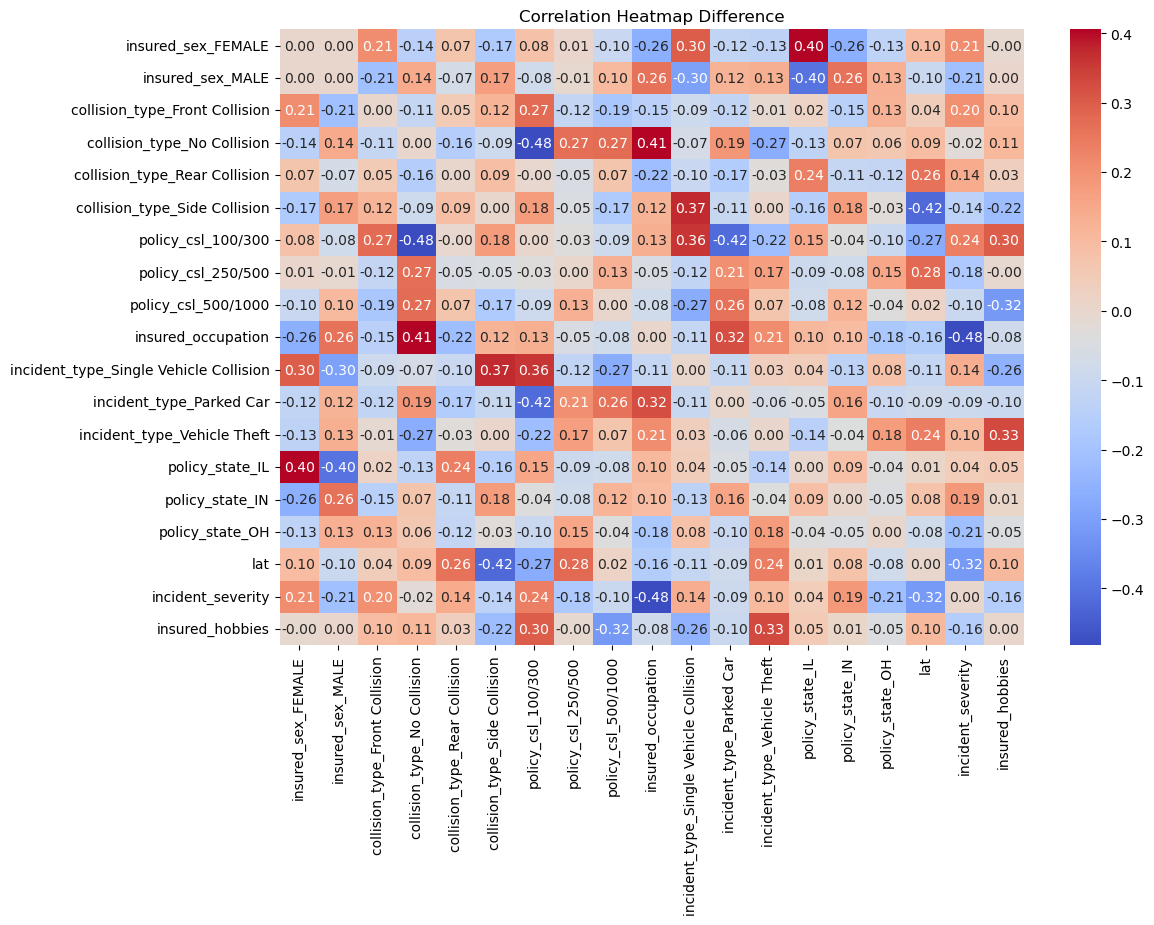

In [363]:
corr_matrix_false_negatives = false_rfecv.corr()

corr_matrix_true_positives = true_rfecv.corr()

diff_matrix = corr_matrix_false_negatives - corr_matrix_true_positives
plt.figure(figsize=(12, 8))
sns.heatmap(diff_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap Difference")
plt.show()

In [359]:
diff = (corr_matrix_false_negatives - corr_matrix_true_positives).unstack()
diff = diff.sort_values(ascending=False)
print(diff)

collision_type_No Collision    insured_occupation                        0.405397
insured_occupation             collision_type_No Collision               0.405397
insured_sex_FEMALE             policy_state_IL                           0.401956
policy_state_IL                insured_sex_FEMALE                        0.401956
collision_type_Side Collision  incident_type_Single Vehicle Collision    0.370991
                                                                           ...   
lat                            collision_type_Side Collision            -0.422064
collision_type_No Collision    policy_csl_100/300                       -0.480456
policy_csl_100/300             collision_type_No Collision              -0.480456
insured_occupation             incident_severity                        -0.482046
incident_severity              insured_occupation                       -0.482046
Length: 361, dtype: float64


In [360]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(corr_matrix_false_negatives.values.flatten(), corr_matrix_true_positives.values.flatten())
print("MSE:", mse)

MSE: 0.029817963061695662


### Adjusting Decision Threshold

In [627]:
threshold = 0.03
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

rf_rfecv_precision_adjusted = precision_score(y_test, y_pred_adjusted)
rf_rfecv_accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
rf_rfecv_recall_adjusted = recall_score(y_test, y_pred_adjusted)
rf_rfecv_f1_adjusted = f1_score(y_test, y_pred_adjusted)

print(f"Decision threshold: {threshold}")
print(f"Adjusted Precision: {rf_rfecv_precision_adjusted}")
print(f"Adjusted Accuracy: {rf_rfecv_accuracy_adjusted}")
print(f"Adjusted Recall: {rf_rfecv_recall_adjusted}")
print(f"Adjusted F1: {rf_rfecv_f1_adjusted}")

Decision threshold: 0.03
Adjusted Precision: 0.5834522111269614
Adjusted Accuracy: 0.8177777777777778
Adjusted Recall: 0.9191011235955057
Adjusted F1: 0.7137870855148342


In [628]:
threshold = 0.02
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

rf_rfecv_precision_adjusted = precision_score(y_test, y_pred_adjusted)
rf_rfecv_accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
rf_rfecv_recall_adjusted = recall_score(y_test, y_pred_adjusted)
rf_rfecv_f1_adjusted = f1_score(y_test, y_pred_adjusted)

print(f"Decision threshold: {threshold}")
print(f"Adjusted Precision: {rf_rfecv_precision_adjusted}")
print(f"Adjusted Accuracy: {rf_rfecv_accuracy_adjusted}")
print(f"Adjusted Recall: {rf_rfecv_recall_adjusted}")
print(f"Adjusted F1: {rf_rfecv_f1_adjusted}")

Decision threshold: 0.02
Adjusted Precision: 0.5750350631136045
Adjusted Accuracy: 0.8122222222222222
Adjusted Recall: 0.9213483146067416
Adjusted F1: 0.7081174438687392
